# Машинное обучение, ФКН ВШЭ

# Практическое задание 11. Несбалансированные задачи

## Общая информация
Дата выдачи: 24.04.2025

Мягкий дедлайн: 13.05.2025 23:59 MSK

Жесткий дедлайн: 18.05.2025 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [ ]:
"""%%bash
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip""";

In [ ]:
!unzip /content/creditcardfraud.zip

Archive:  /content/creditcardfraud.zip
  inflating: creditcard.csv          


In [ ]:
df = pd.read_csv('creditcard.csv')

In [ ]:
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [ ]:
df.Class.value_counts()

,count
Class,
0,284315
1,492


Как можно заметить положительных классов меньше 1%.

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [ ]:
def hour(time):
  hours = time // 3600 % 24
  return hours

def day(time):
  day = time // 3600 // 24
  return day

In [ ]:
df['hour'] = df.Time.apply(hour)
df['day'] = df.Time.apply(day)

Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

In [ ]:
sorted_index = np.argsort(df.hour.value_counts().index) # Первый пункт
values = df.hour.value_counts().values[sorted_index]
indexes = df.hour.value_counts().index[sorted_index]

pos_df = df[df.Class == 1] # Второй пункт

hour_groupby = df.groupby('hour')['Class'].mean() * 100
sorted_index_pos = np.argsort(pos_df.hour.value_counts().index)
values_pos = pos_df.hour.value_counts().values[sorted_index_pos]
indexes_pos = pos_df.hour.value_counts().index[sorted_index_pos]

sorted_index_day = np.argsort(df.day.value_counts().index) # Третий пункт
values_day = df.day.value_counts().values[sorted_index_day]
indexes_day = df.day.value_counts().index[sorted_index_day]

day_groupby = df.groupby('day')['Class'].mean() * 100
sorted_index_pos_day = np.argsort(pos_df.day.value_counts().index)
values_pos_day = pos_df.day.value_counts().values[sorted_index_pos_day]
indexes_pos_day = pos_df.day.value_counts().index[sorted_index_pos_day]

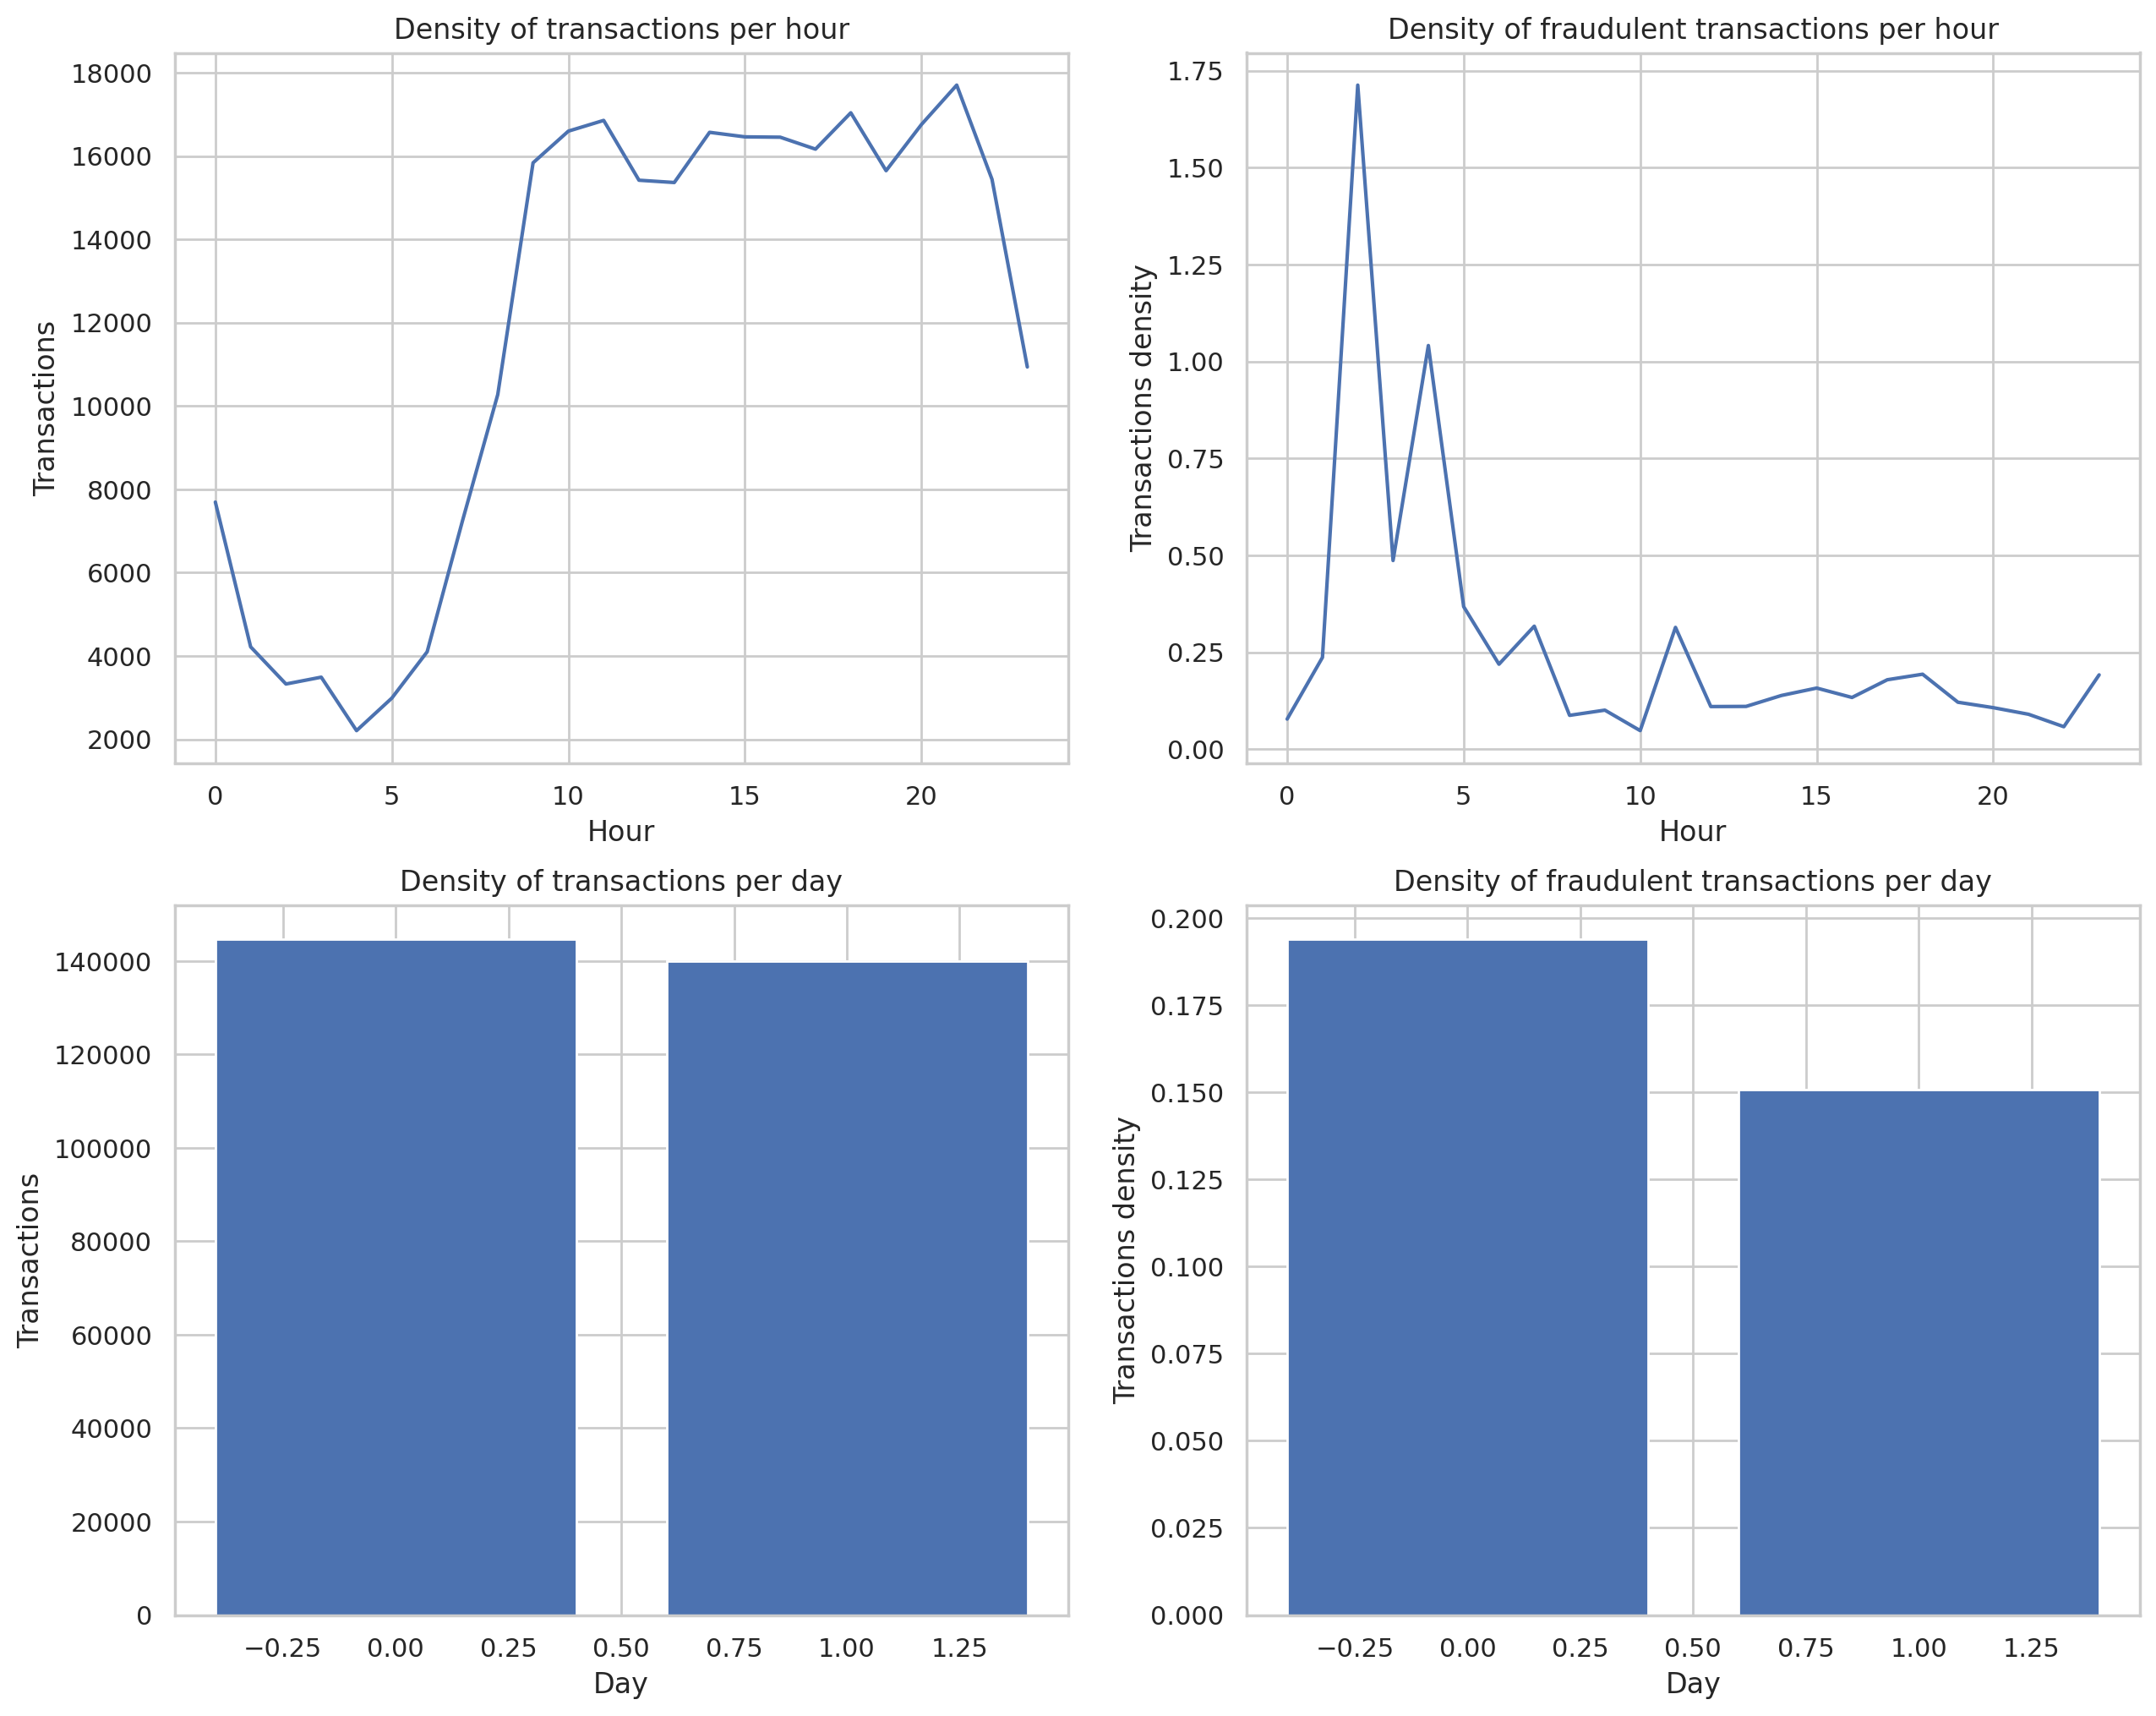

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15,12), dpi=200)

axs[0][0].set_title('Density of transactions per hour')
axs[0][0].plot(indexes, values)
axs[0][0].set_xlabel('Hour')
axs[0][0].set_ylabel('Transactions')
axs[0][0].grid(True)

axs[0][1].set_title('Density of fraudulent transactions per hour')
axs[0][1].plot(hour_groupby.index, hour_groupby.values)
axs[0][1].set_xlabel('Hour')
axs[0][1].set_ylabel('Transactions density')
axs[0][1].grid(True)

axs[1][0].set_title('Density of transactions per day')
axs[1][0].bar(indexes_day, values_day)
axs[1][0].set_xlabel('Day')
axs[1][0].set_ylabel('Transactions')
axs[1][0].grid(True)

axs[1][1].set_title('Density of fraudulent transactions per day')
axs[1][1].bar(day_groupby.index, day_groupby.values)
axs[1][1].set_xlabel('Day')
axs[1][1].set_ylabel('Transactions density')
axs[1][1].grid(True)

По графику можно сказать, что чаще всего мошеннические операции происходят в 3 часа и 5 часов (не по нашему времени, а по времени, который мы рассчитали). Честно говоря без понятние как интерпритировать такое время, люди по идеи спят в такое время...

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

Сперва построим распределение признаков для каждого из классов

In [ ]:
neg_df = df[df.Class == 0]

In [ ]:
from scipy.stats import pearsonr, spearmanr #Линейная и нелинейная связь
col_names = df.columns[df.columns != 'Class']
main_feat = []
for i in col_names:
  if np.abs(pearsonr(df.Class, df[i])[0]) >= 0.2 or np.abs(spearmanr(df.Class, df[i])[0]) >= 0.2:
    main_feat.append(i)

In [ ]:
main_feat # Получаем признаки, которые коррелируют с таргетом

['V10', 'V12', 'V14', 'V17']

Теперь построим распределения для каждого из этих признаков по кажому классу.

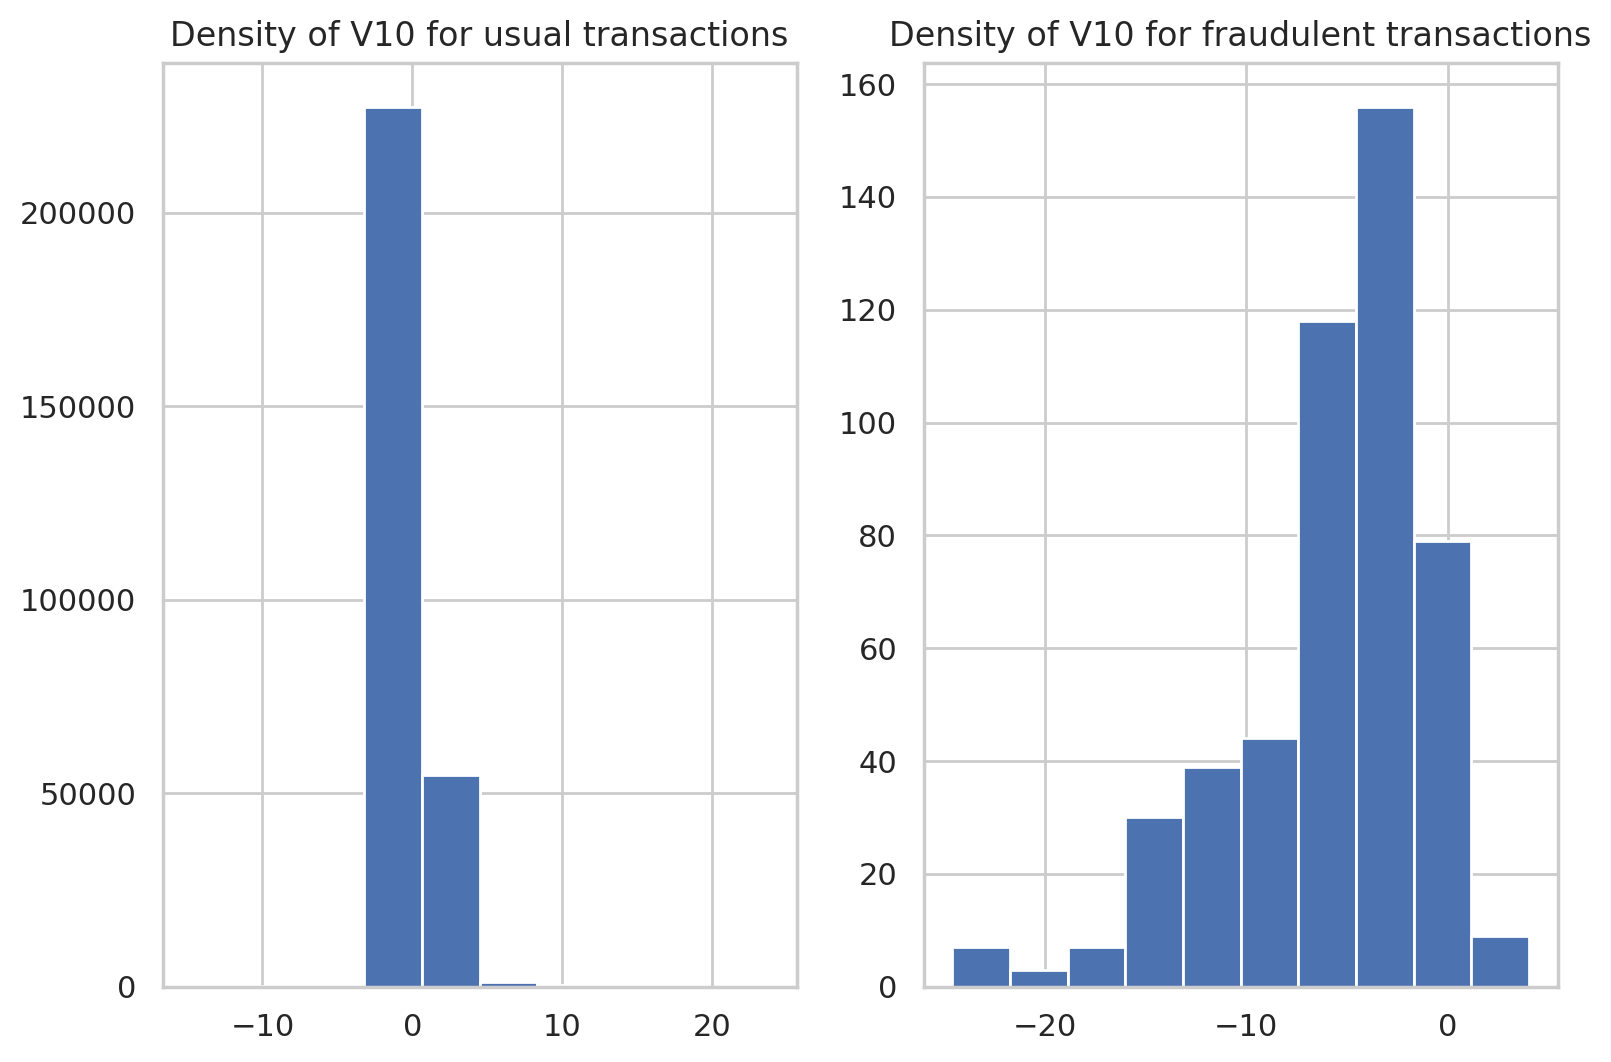

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9,6), dpi=200, squeeze=False)

axs[0][0].set_title('Density of V10 for fraudulent transactions')
axs[0][0].hist(neg_df['V10'])
axs[0][0].grid(True)

axs[0][1].set_title('Density of V10 for usual transactions')
axs[0][1].hist(pos_df['V10'])
axs[0][1].grid(True)

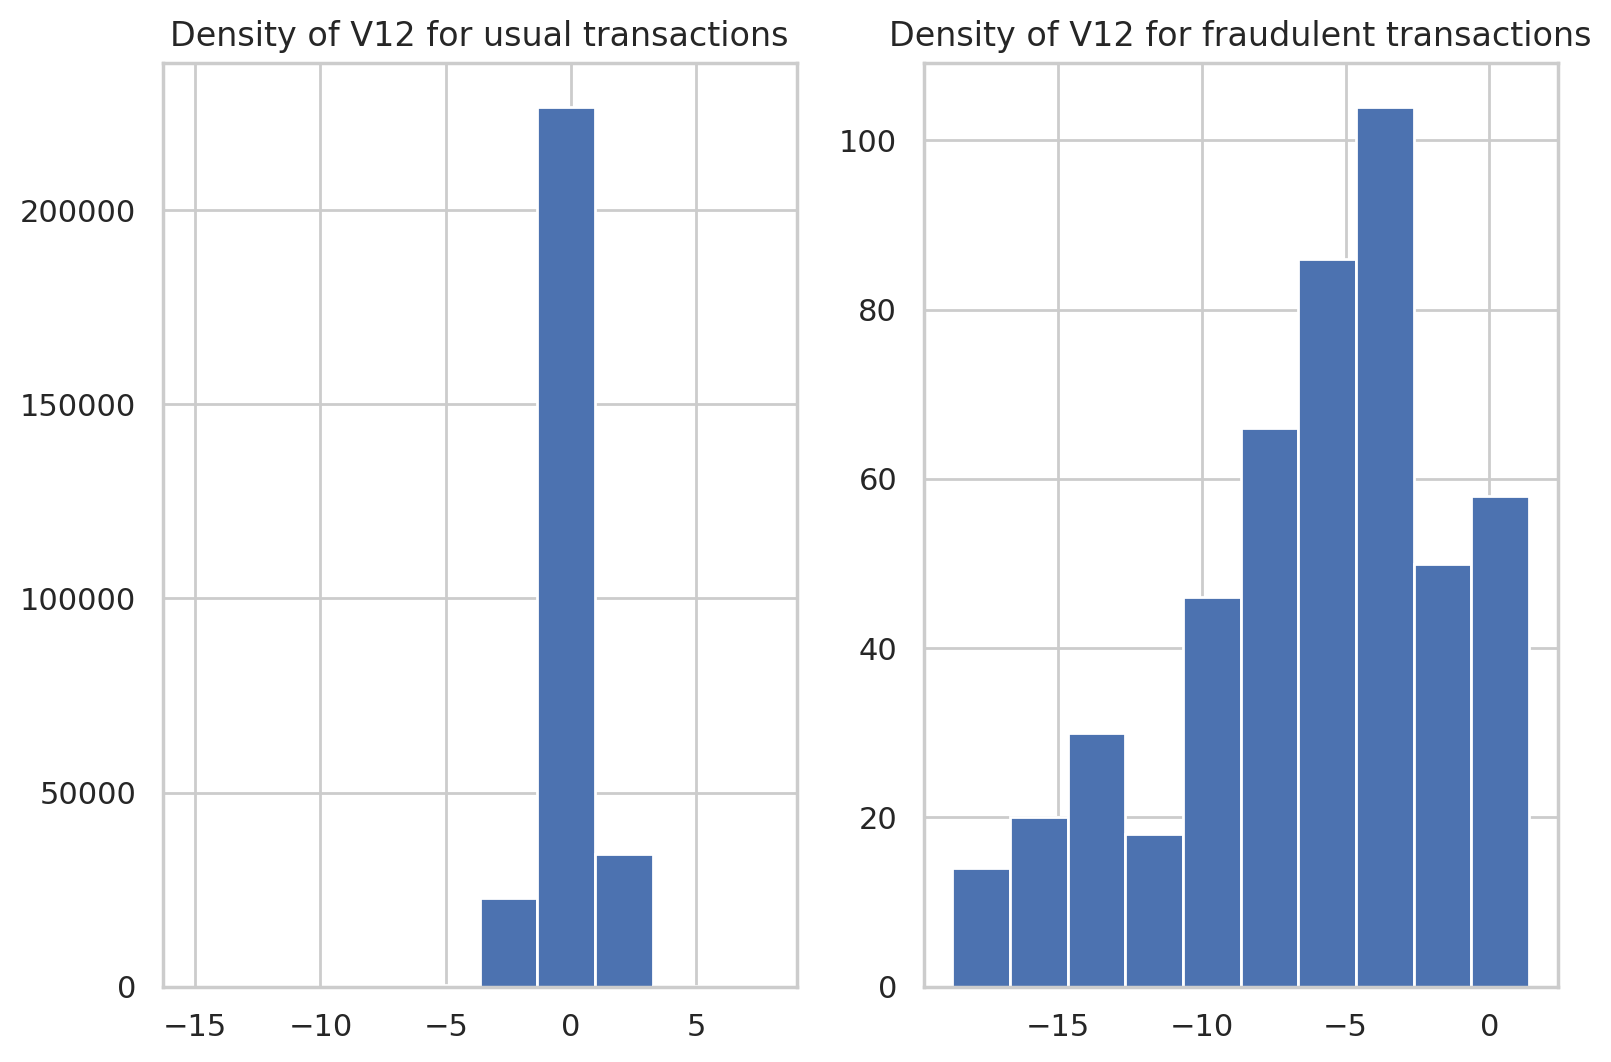

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9,6), dpi=200, squeeze=False)

axs[0][0].set_title('Density of V12 for fraudulent transactions')
axs[0][0].hist(neg_df['V12'])
axs[0][0].grid(True)

axs[0][1].set_title('Density of V12 for usual transactions')
axs[0][1].hist(pos_df['V12'])
axs[0][1].grid(True)

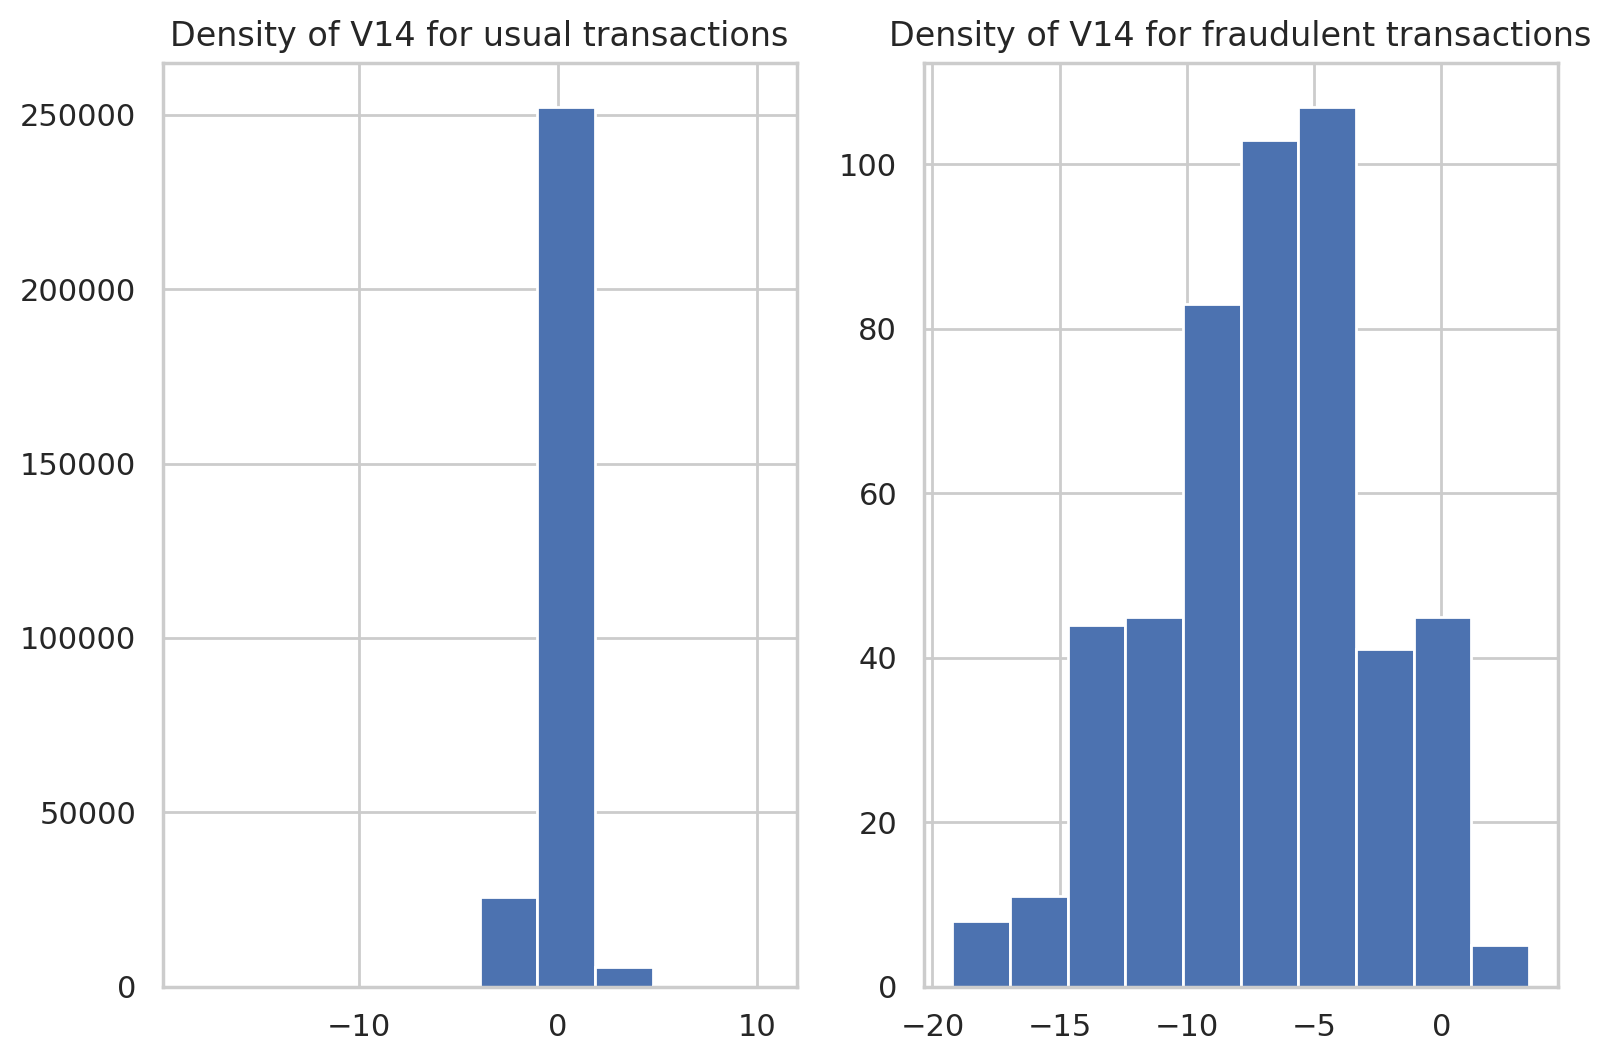

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9,6), dpi=200, squeeze=False)

axs[0][0].set_title('Density of V14 for fraudulent transactions')
axs[0][0].hist(neg_df['V14'])
axs[0][0].grid(True)

axs[0][1].set_title('Density of V14 for usual transactions')
axs[0][1].hist(pos_df['V14'])
axs[0][1].grid(True)

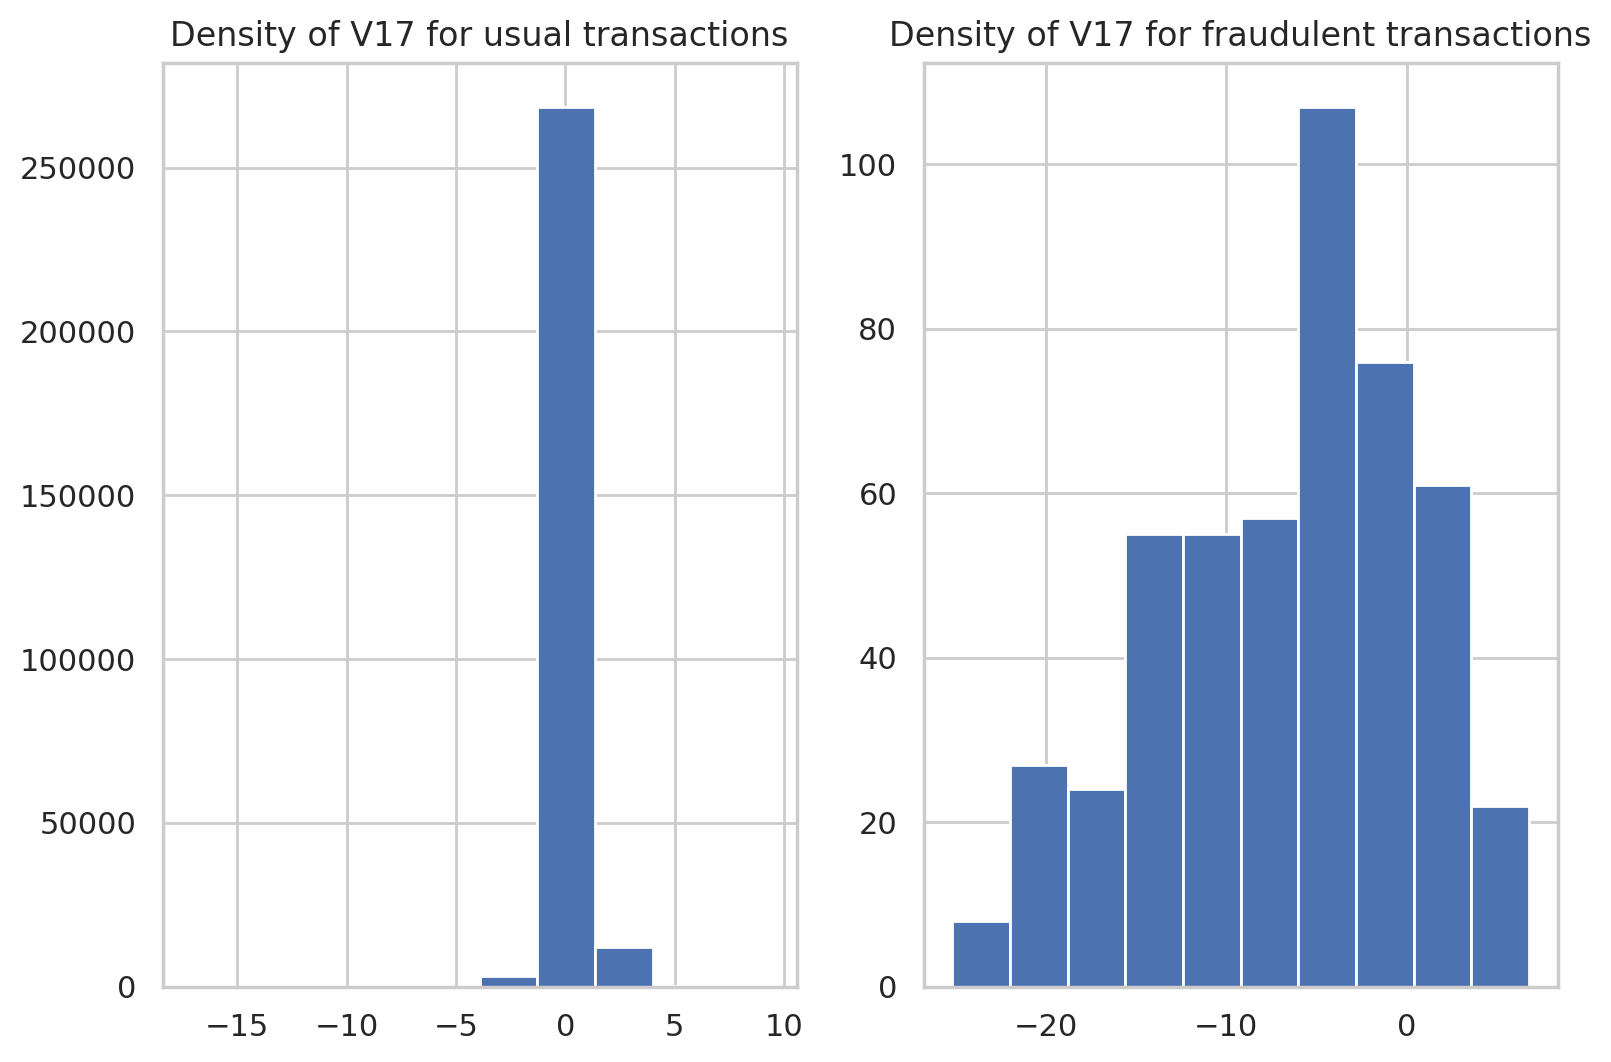

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9,6), dpi=200, squeeze=False)

axs[0][0].set_title('Density of V17 for fraudulent transactions')
axs[0][0].hist(neg_df['V17'])
axs[0][0].grid(True)

axs[0][1].set_title('Density of V17 for usual transactions')
axs[0][1].hist(pos_df['V17'])
axs[0][1].grid(True)

Можно заметить, что у этих признаков сильно больше значение, если это мошенническая транзакция.

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим.

In [ ]:
X = df.loc[:, ~df.columns.isin(['Class', 'Time'])] # Time убрал, потому что ненужная фича (сверху об этом говорилось тоже)
y = df['Class']

In [ ]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,hour,day
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0,0.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0,0.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0,0.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0,0.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_notrain, y_train, y_notrain = train_test_split(X,y, test_size=0.2, random_state=0, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_notrain, y_notrain, test_size=0.5, random_state=0, shuffle=False)

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога.

Accuracy будет равен около 1.

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, auc

In [ ]:
def auc_pr(y_true, y_pred, c:float = 0.5):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  if np.array(y_pred).dtype.kind in 'bi':
    y_pred = y_pred
  else:
    y_pred = (np.array(y_pred) >= c).astype(int)

  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  auc_pr_score = auc(recall, precision)
  return auc_pr_score

In [ ]:
def Kappa_Koena(y_true, y_pred, c:float = 0.5):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  if np.array(y_pred).dtype.kind in 'bi':
    y_pred = y_pred
  else:
    y_pred = (np.array(y_pred) >= c).astype(int)

  len_data = len(y_true)

  p_0 = accuracy_score(y_true, y_pred)
  cm = confusion_matrix(y_true, y_pred)
  TN, FP, FN, TP = cm.ravel()

  p_e_pos = ((TP+FP)/len_data) * ((TP+FN)/len_data)
  p_e_neg = ((TN+FP)/len_data) * ((TN+FN)/len_data)
  p_e = p_e_pos + p_e_neg
  k = (p_0-p_e)/(1-p_e)

  return k

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом.

In [ ]:
def MCC(y_true, y_pred, c:float = 0.5):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  if np.array(y_pred).dtype.kind in 'bi':
    y_pred = y_pred
  else:
    y_pred = (np.array(y_pred) >= c).astype(int)

  cm = confusion_matrix(y_true, y_pred)
  TN, FP, FN, TP = cm.ravel()

  if np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) == 0:
    MCC_metric = np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
  else:
    MCC_metric = (TP*TN-FN*FP)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

  return MCC_metric

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [ ]:
naive_pred = np.ones(len(df))

print(f"Metrics of MCC {MCC(df.Class, naive_pred)}")
print(f"Metrics of Kappa Koen {Kappa_Koena(df.Class, naive_pred)}")
print(f"Metrics of AUC-PR {auc_pr(df.Class, naive_pred)}")

Metrics of MCC 0.0
Metrics of Kappa Koen 0.0
Metrics of AUC-PR 0.50086374281531


Как мы можно заметить, мы получаем значение метрики равную 0 у МСС и Каппа Коэна и 0.5 у AUC-PR, это означает, что наше предсказание является случайным, а это худщий вариант из всего возможного.

Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`).

In [ ]:
!pip install catboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 24.3 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
import optuna
import torch

if torch.cuda.is_available():
  device = 'GPU'
else:
  device = 'CPU'

In [ ]:
device

'GPU'

Подберем гиперпараметры через optuna

In [ ]:
def objective(trial):
      param = {
      'iterations' : trial.suggest_categorical('iterations', list(range(1000, 7001))),
      'learning_rate' : trial.suggest_float('learning_rate', 0.05, 0.5),
      'depth' : trial.suggest_categorical('depth', list(range(2, 10))),
      }

      model = CatBoostClassifier(**param,random_state=52, verbose=False, task_type=device)
      model_fitted = model.fit(X_train, y_train)
      pred = model_fitted.predict(X_val)
      kk_score = Kappa_Koena(y_val, pred)
      mcc_score = MCC(y_val, pred)
      auc_pr_score = auc_pr(y_val, pred)

      return kk_score, mcc_score, auc_pr_score

study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
study.optimize(objective, n_trials=5)

trials = study.best_trials

best_trials = study.best_trials

for i in range(len(best_trials)):
  print(f'{best_trials[i].params} best metrics {best_trials[i].values}')

[I 2025-05-08 15:59:47,433] A new study created in memory with name: no-name-6f8d771d-8047-4b7c-a37d-9e398ffb7675
[I 2025-05-08 16:00:34,723] Trial 0 finished with values: [0.8349082578911322, 0.846524079607583, 0.8587538994881062] and parameters: {'iterations': 5211, 'learning_rate': 0.10701882443031555, 'depth': 7}.
[I 2025-05-08 16:00:44,020] Trial 1 finished with values: [0.8384510754991502, 0.8467917871368241, 0.8556703061888992] and parameters: {'iterations': 1197, 'learning_rate': 0.2892339374918085, 'depth': 5}.
[I 2025-05-08 16:01:09,296] Trial 2 finished with values: [0.8295104733941121, 0.8363760288811886, 0.8437800622864601] and parameters: {'iterations': 4581, 'learning_rate': 0.09608640282386427, 'depth': 3}.
[I 2025-05-08 16:01:53,351] Trial 3 finished with values: [0.7908837933287675, 0.8018871162147391, 0.8136052966128361] and parameters: {'iterations': 6095, 'learning_rate': 0.30107263890468633, 'depth': 6}.
[I 2025-05-08 16:02:09,197] Trial 4 finished with values: [0

{'iterations': 5211, 'learning_rate': 0.10701882443031555, 'depth': 7} best metrics [0.8349082578911322, 0.846524079607583, 0.8587538994881062]
{'iterations': 1197, 'learning_rate': 0.2892339374918085, 'depth': 5} best metrics [0.8384510754991502, 0.8467917871368241, 0.8556703061888992]


In [ ]:
model = CatBoostClassifier(**{'iterations': 5211, 'learning_rate': 0.10701882443031555, 'depth': 7}, random_state=52, verbose=False, task_type=device)

model.fit(X_train, y_train)
pred = model.predict(X_test)

print(f"MCC score {MCC(y_test, pred)}")
print(f"Kappa Koena score {Kappa_Koena(y_test, pred)}")
print(f"AUC-PR score {auc_pr(y_test, pred)}")

MCC score 0.7754834690252622
Kappa Koena score 0.7690752614163152
AUC-PR score 0.7822084504408323


Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [ ]:
zeros = len(y_train[y_train == 0])
ones = len(y_train[y_train == 1])

scale = zeros/ones

model_scale = CatBoostClassifier(
    **{'iterations': 5211, 'learning_rate': 0.10701882443031555, 'depth': 7},
    random_state=52, verbose=False,
    scale_pos_weight=scale, task_type=device
)
model_scale.fit(X_train, y_train)
pred_scale = model_scale.predict(X_test)

print(f"MCC score {MCC(y_test, pred_scale)}")
print(f"Kappa Koena score {Kappa_Koena(y_test, pred_scale)}")
print(f"AUC-PR score {auc_pr(y_test, pred_scale)}")

MCC score 0.7441944677557768
Kappa Koena score 0.743992894025702
AUC-PR score 0.7446940779688928


In [ ]:
print(scale)

545.3908872901678


Ну не прям испортился, но стало хуже (я когда несколько дней назад запускал это метрики были около 0.4, хз почему меняется при каждом запуске).

Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части.

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [ ]:
def objective(trial):
      param = {
      'iterations' : trial.suggest_categorical('iterations', list(range(1000, 7001))),
      'learning_rate' : trial.suggest_float('learning_rate', 0.05, 0.5),
      'depth' : trial.suggest_categorical('depth', list(range(2, 11))),
      'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 0.1, 500),
      }

      c = trial.suggest_float('c', 0.5, 0.9)

      model = CatBoostClassifier(**param,random_state=52, verbose=False, task_type=device)
      model_fitted = model.fit(X_train, y_train)
      pred_proba = model_fitted.predict_proba(X_val)[:, 1]
      kk_score = Kappa_Koena(y_val, pred_proba, c)
      mcc_score = MCC(y_val, pred_proba, c)
      auc_pr_score = auc_pr(y_val, pred_proba, c)

      return kk_score, mcc_score, auc_pr_score

study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
study.optimize(objective, n_trials=10)

trials = study.best_trials

best_trials = study.best_trials

for i in range(len(best_trials)):
  print(f'{best_trials[i].params} best metrics {best_trials[i].values}')

[I 2025-05-08 16:15:05,263] A new study created in memory with name: no-name-7c8da593-a4a8-41d5-84e8-f248d9621e70
[I 2025-05-08 16:15:19,286] Trial 0 finished with values: [0.8629323611389199, 0.8687954158569225, 0.8750983576857231] and parameters: {'iterations': 1942, 'learning_rate': 0.2648526225586258, 'depth': 5, 'scale_pos_weight': 451.9029402895917, 'c': 0.6620990754087369}.
[I 2025-05-08 16:15:31,656] Trial 1 finished with values: [0.8418450320833691, 0.8475648123459499, 0.8537771890801683] and parameters: {'iterations': 2182, 'learning_rate': 0.1586970608999058, 'depth': 3, 'scale_pos_weight': 438.7355297974924, 'c': 0.6119229108288744}.
[I 2025-05-08 16:15:59,189] Trial 2 finished with values: [0.8418450320833691, 0.8475648123459499, 0.8537771890801683] and parameters: {'iterations': 1683, 'learning_rate': 0.2191225519333404, 'depth': 9, 'scale_pos_weight': 93.53617912922067, 'c': 0.7185875411471614}.
[I 2025-05-08 16:16:56,184] Trial 3 finished with values: [0.850821664219848

{'iterations': 5198, 'learning_rate': 0.4298854417656346, 'depth': 6, 'scale_pos_weight': 290.5435672221376, 'c': 0.636739845062786} best metrics [0.8721328550455841, 0.8793511804320202, 0.8870031195904851]


In [ ]:
model_cat_new = CatBoostClassifier(
    **{'iterations': 5198, 'learning_rate': 0.4298854417656346, 'depth': 6, 'scale_pos_weight': 290.5435672221376},
    random_state=52, verbose=False, task_type=device
                                   )

model_cat_new.fit(X_train, y_train)
pred_proba = model_cat_new.predict_proba(X_test)[:, 1]

print(f"MCC score {MCC(y_test, pred_proba, c = 0.636739845062786)}")
print(f"Kappa Koena score {Kappa_Koena(y_test, pred_proba, c = 0.636739845062786)}")
print(f"AUC-PR score {auc_pr(y_test, pred_proba, c = 0.636739845062786)}")

MCC score 0.7824309099074692
Kappa Koena score 0.7803305381421584
AUC-PR score 0.7847943285954593


Теперь стало действительно чуть лучше.

**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса.

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [ ]:
!pip3 install imbalanced-learn
# conda install -c conda-forge imbalanced-learn

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку.

In [ ]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [ ]:
sm = SMOTE(random_state=52)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [ ]:
y_train_sm.value_counts()

,count
Class,
0,227428
1,227428


In [ ]:
sm_part = SMOTE(sampling_strategy=0.12, random_state=52)
X_train_sm_part, y_train_sm_part = sm_part.fit_resample(X_train, y_train)

In [ ]:
y_train_sm_part.value_counts()

,count
Class,
0,227428
1,27291


Теперь переберем гиперпараметры и обучим обе модели (сперва для польного ресэмплинга, потом для частичного).

In [ ]:
def objective(trial):
      param = {
      'iterations' : trial.suggest_categorical('iterations', list(range(1000, 7001))),
      'learning_rate' : trial.suggest_float('learning_rate', 0.05, 0.5),
      'depth' : trial.suggest_categorical('depth', list(range(2, 11))),
      }


      model = CatBoostClassifier(**param,random_state=52, verbose=False, task_type=device)
      model_fitted = model.fit(X_train_sm, y_train_sm)
      pred = model_fitted.predict(X_val)
      kk_score = Kappa_Koena(y_val, pred)
      mcc_score = MCC(y_val, pred)
      auc_pr_score = auc_pr(y_val, pred)

      return kk_score, mcc_score, auc_pr_score

study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
study.optimize(objective, n_trials=10)

trials = study.best_trials

best_trials = study.best_trials

for i in range(len(best_trials)):
  print(f'{best_trials[i].params} best metrics {best_trials[i].values}')

[I 2025-05-08 16:57:09,057] A new study created in memory with name: no-name-1d525a15-ad9f-452b-9d8c-fa477b1de5c2
[I 2025-05-08 16:57:29,476] Trial 0 finished with values: [0.8418450320833691, 0.8475648123459499, 0.8537771890801683] and parameters: {'iterations': 1281, 'learning_rate': 0.25762202523915817, 'depth': 7}.
[I 2025-05-08 16:57:54,858] Trial 1 finished with values: [0.8418450320833691, 0.8475648123459499, 0.8537771890801683] and parameters: {'iterations': 2869, 'learning_rate': 0.09526737470732231, 'depth': 5}.
[I 2025-05-08 16:58:23,781] Trial 2 finished with values: [0.8418450320833691, 0.8475648123459499, 0.8537771890801683] and parameters: {'iterations': 2939, 'learning_rate': 0.2588294857953823, 'depth': 6}.
[I 2025-05-08 16:59:45,614] Trial 3 finished with values: [0.8539231496861388, 0.8586097664478315, 0.8637473056369966] and parameters: {'iterations': 7000, 'learning_rate': 0.4685300782003788, 'depth': 7}.
[I 2025-05-08 17:00:06,756] Trial 4 finished with values: [0

{'iterations': 7000, 'learning_rate': 0.4685300782003788, 'depth': 7} best metrics [0.8539231496861388, 0.8586097664478315, 0.8637473056369966]


In [ ]:
def objective(trial):
      param = {
      'iterations' : trial.suggest_categorical('iterations', list(range(1000, 7001))),
      'learning_rate' : trial.suggest_float('learning_rate', 0.05, 0.5),
      'depth' : trial.suggest_categorical('depth', list(range(2, 11))),
      }

      model = CatBoostClassifier(**param,random_state=52, verbose=False, task_type=device)
      model_fitted = model.fit(X_train_sm_part, y_train_sm_part)
      pred_proba = model_fitted.predict(X_val)
      kk_score = Kappa_Koena(y_val, pred_proba)
      mcc_score = MCC(y_val, pred_proba)
      auc_pr_score = auc_pr(y_val, pred_proba)

      return kk_score, mcc_score, auc_pr_score


study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
study.optimize(objective, n_trials=10)

trials = study.best_trials

best_trials = study.best_trials

for i in range(len(best_trials)):
  print(f'{best_trials[i].params} best metrics {best_trials[i].values}')

[I 2025-05-08 17:07:11,604] A new study created in memory with name: no-name-4ce618d2-8211-44cf-80f5-e968a6e6c085
[I 2025-05-08 17:07:55,210] Trial 0 finished with values: [0.8418450320833691, 0.8475648123459499, 0.8537771890801683] and parameters: {'iterations': 2725, 'learning_rate': 0.4760862727547491, 'depth': 9}.
[I 2025-05-08 17:08:24,798] Trial 1 finished with values: [0.8539231496861388, 0.8586097664478315, 0.8637473056369966] and parameters: {'iterations': 4263, 'learning_rate': 0.1845857371156045, 'depth': 5}.
[I 2025-05-08 17:08:36,764] Trial 2 finished with values: [0.8330550282127301, 0.8376271137219123, 0.8427029919594595] and parameters: {'iterations': 1420, 'learning_rate': 0.31559045994842144, 'depth': 6}.
[I 2025-05-08 17:08:45,617] Trial 3 finished with values: [0.8539231496861388, 0.8586097664478315, 0.8637473056369966] and parameters: {'iterations': 1362, 'learning_rate': 0.2482029220383553, 'depth': 5}.
[I 2025-05-08 17:09:20,696] Trial 4 finished with values: [0.

{'iterations': 1524, 'learning_rate': 0.45751881764286245, 'depth': 4} best metrics [0.8629323611389199, 0.8687954158569225, 0.8750983576857231]


Теперь обучим

In [ ]:
model_sm = CatBoostClassifier(
    **{'iterations': 7000, 'learning_rate': 0.4685300782003788, 'depth': 7},
    random_state=52, verbose=False, task_type=device
                                   )

model_sm.fit(X_train_sm, y_train_sm)
pred_proba_sm = model_sm.predict_proba(X_test)[:, 1]

print(f"MCC score for full SMOTE {MCC(y_test, pred_proba_sm)}")
print(f"Kappa Koena score for full SMOTE {Kappa_Koena(y_test, pred_proba_sm)}")
print(f"AUC-PR score for full SMOTE {auc_pr(y_test, pred_proba_sm)}")

MCC score for full SMOTE 0.6976351100712623
Kappa Koena score for full SMOTE 0.6974461474849205
AUC-PR score for full SMOTE 0.6981748369954542


In [ ]:
model_sm_part = CatBoostClassifier(
    **{'iterations': 1524, 'learning_rate': 0.45751881764286245, 'depth': 4},
    random_state=52, verbose=False, task_type=device
                                   )

model_sm_part.fit(X_train_sm_part, y_train_sm_part)
pred_proba_sm_part = model_sm_part.predict(X_test)

print(f"MCC score for partly SMOTE (0.12) {MCC(y_test, pred_proba_sm_part)}")
print(f"Kappa Koena score for partly SMOTE (0.12) {Kappa_Koena(y_test, pred_proba_sm_part)}")
print(f"AUC-PR score for partly SMOTE (0.12) {Kappa_Koena(y_test, pred_proba_sm_part)}")

MCC score for partly SMOTE (0.12) 0.7110586906187203
Kappa Koena score for partly SMOTE (0.12) 0.7108828212297992
AUC-PR score for partly SMOTE (0.12) 0.7108828212297992


Ну если честно оба так себе, но неполный баланс классов намного лучше, чем 1:1.

**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

BorderlineSMOTE - В отличие от классического SMOTE, который генерирует синтетические примеры для всех объектов миноритарного класса, BorderlineSMOTE фокусируется только на тех, которые находятся на границе разделения классов ("borderline instances").

SVM-SMOTE - Использует метод опорных векторов (SVM) для определения наиболее информативных объектов миноритарного класса. Потом синтетические примеры создаются вблизи опорных векторов (support vectors) — точек, которые критически важны для разделения классов.

K-Means-SMOTE - сначала кластеризует данные с помощью K-Means, а затем применяет SMOTE только к тем кластерам, где миноритарный класс сильно недостаточно представлен. Это помогает избежать генерации лишних примеров в "бесполезных" областях и сосредоточиться на ключевых зонах дисбаланса.

ADASYN - Он создает больше синтетических примеров в тех местах, где миноритарный класс особенно слабо представлен по сравнению с мажоритарным. Чем сложнее классифицировать объекты миноритарного класса в определенной области, тем больше новых примеров там генерируется, что помогает сбалансировать данные более осмысленно.

Теперь попробуйте сравнить качество всех методов на наших данных.

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, ADASYN

In [ ]:
model_bonus = CatBoostClassifier(
    **{'iterations': 3000, 'learning_rate': 0.1, 'depth': 7},
    random_state=52, verbose=False, task_type=device
                                   ) #Взял рандомные гиперпараметры, потому что уже лень подобрать по идеи не все будет так ужасно

In [ ]:
BS = BorderlineSMOTE(sampling_strategy=0.15, random_state=52)
X_train_bs, y_train_bs = BS.fit_resample(X_train, y_train)

model_bonus.fit(X_train_bs, y_train_bs)
pred_bs = model_bonus.predict(X_test)

print(f"MCC score for partly Borderline SMOTE (0.15) {MCC(y_test, pred_bs)}")
print(f"Kappa Koena score for partly Borderline SMOTE (0.15) {Kappa_Koena(y_test, pred_bs)}")
print(f"AUC-PR score for partly Borderline SMOTE (0.15) {Kappa_Koena(y_test, pred_bs)}")

MCC score for partly Borderline SMOTE (0.15) 0.7110586906187203
Kappa Koena score for partly Borderline SMOTE (0.15) 0.7108828212297992
AUC-PR score for partly Borderline SMOTE (0.15) 0.7108828212297992


In [ ]:
from sklearn.svm import SVC
SVMS = SVMSMOTE(sampling_strategy=0.15, random_state=52, svm_estimator=SVC(kernel='rbf',max_iter=3000, gamma=50))
X_train_svms, y_train_svms = SVMS.fit_resample(X_train, y_train)

model_bonus.fit(X_train_svms, y_train_svms)
pred_SVMS = model_bonus.predict(X_test)

print(f"MCC score for partly SVM SMOTE (0.15) {MCC(y_test, pred_SVMS)}")
print(f"Kappa Koena score for partly SVM SMOTE (0.15) {Kappa_Koena(y_test, pred_SVMS)}")
print(f"AUC-PR score for partly SVM SMOTE (0.15) {Kappa_Koena(y_test, pred_SVMS)}")

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MCC score for partly SVM SMOTE (0.15) 0.7110586906187203
Kappa Koena score for partly SVM SMOTE (0.15) 0.7108828212297992
AUC-PR score for partly SVM SMOTE (0.15) 0.7108828212297992


In [ ]:
kms = KMeansSMOTE(sampling_strategy=0.15, random_state=52, cluster_balance_threshold=0.00001)
X_train_kms, y_train_kms = kms.fit_resample(X_train, y_train)

model_bonus.fit(X_train_kms, y_train_kms)
pred_kms = model_bonus.predict(X_test)

print(f"MCC score for partly KMeans SMOTE (0.15) {MCC(y_test, pred_kms)}")
print(f"Kappa Koena score for partly KMeans SMOTE (0.15) {Kappa_Koena(y_test, pred_kms)}")
print(f"AUC-PR score for partly KMeans SMOTE (0.15) {Kappa_Koena(y_test, pred_kms)}")

MCC score for partly KMeans SMOTE (0.15) 0.7754834690252622
Kappa Koena score for partly KMeans SMOTE (0.15) 0.7690752614163152
AUC-PR score for partly KMeans SMOTE (0.15) 0.7690752614163152


In [ ]:
ad = ADASYN(sampling_strategy=0.15, random_state=52)
X_train_ad, y_train_ad = ad.fit_resample(X_train, y_train)

model_bonus.fit(X_train_ad, y_train_ad)
pred_ad = model_bonus.predict(X_test)

print(f"MCC score for partly ADASYN (0.15) {MCC(y_test, pred_ad)}")
print(f"Kappa Koena score for partly ADASYN (0.15) {Kappa_Koena(y_test, pred_ad)}")
print(f"AUC-PR score for partly ADASYN (0.15) {Kappa_Koena(y_test, pred_ad)}")

MCC score for partly ADASYN (0.15) 0.7270618976581941
Kappa Koena score for partly ADASYN (0.15) 0.7270618976582063
AUC-PR score for partly ADASYN (0.15) 0.7270618976582063


Итоги:

**BorderlineSMOTE**: метод хороший, в потенциале лучше, чем обычный SMOTE, так как есть больше гиперпараметров, которые можно подобрать

**SVMSMOTE**: Работает мегамедленно, надо очень сильно настроить. По результатам такой же как и BorderlineSMOTE.

**KMeans SMOTE**: Очень хорошо, но опять же нужно подобрать гиперпараметры

**ADASYN**: Неплохо, но явно проигрывает Kmeans.

**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
ru = RandomUnderSampler(sampling_strategy=0.15, random_state=52)

In [ ]:
X_train_ru, y_train_ru = ru.fit_resample(X_train, y_train)

In [ ]:
y_train_ru.value_counts()

,count
Class,
0,2780
1,417


In [ ]:
model_sm_part = CatBoostClassifier(
    **{'iterations': 3000, 'learning_rate': 0.1, 'depth': 7},
    random_state=52, verbose=False
                                   )

model_sm_part.fit(X_train_ru, y_train_ru)
pred_proba_ru = model_sm_part.predict(X_test)

print(f"MCC score for undersampling (0.15) {MCC(y_test, pred_proba_ru)}")
print(f"Kappa Koena score for undersampling (0.15) {Kappa_Koena(y_test, pred_proba_ru)}")
print(f"AUC-PR score for undersampling (0.15) {auc_pr(y_test, pred_proba_ru)}")

MCC score for undersampling (0.15) 0.43256554880375947
Kappa Koena score for undersampling (0.15) 0.38024569021071897
AUC-PR score for undersampling (0.15) 0.49277395508102795


In [ ]:
ru_4 = RandomUnderSampler(sampling_strategy=0.4, random_state=52)
X_train_ru_4, y_train_ru_4 = ru_4.fit_resample(X_train, y_train)

In [ ]:
model_sm_part = CatBoostClassifier(
    **{'iterations': 3000, 'learning_rate': 0.1, 'depth': 7},
    random_state=52, verbose=False
                                   )

model_sm_part.fit(X_train_ru_4, y_train_ru_4)
pred_proba_ru_4 = model_sm_part.predict(X_test)

print(f"MCC score for undersampling (0.4) {MCC(y_test, pred_proba_ru_4)}")
print(f"Kappa Koena score for undersampling (0.4) {Kappa_Koena(y_test, pred_proba_ru_4)}")
print(f"AUC-PR score for undersampling (0.4) {auc_pr(y_test, pred_proba_ru_4)}")

MCC score for undersampling (0.4) 0.29695217332192847
Kappa Koena score for undersampling (0.4) 0.20810284595281428
AUC-PR score for undersampling (0.4) 0.42481039930658815


In [ ]:
ru_full = RandomUnderSampler(sampling_strategy=1, random_state=52)
X_train_ru_full, y_train_ru_full = ru_full.fit_resample(X_train, y_train)

In [ ]:
model_sm_part = CatBoostClassifier(
    **{'iterations': 3000, 'learning_rate': 0.1, 'depth': 7},
    random_state=52, verbose=False
                                   )

model_sm_part.fit(X_train_ru_full, y_train_ru_full)
pred_proba_ru_full = model_sm_part.predict(X_test)

print(f"MCC score for undersampling (full) {MCC(y_test, pred_proba_ru_full)}")
print(f"Kappa Koena score for undersampling (full) {Kappa_Koena(y_test, pred_proba_ru_full)}")
print(f"AUC-PR score for undersampling (full) {auc_pr(y_test, pred_proba_ru_full)}")

MCC score for undersampling (full) 0.13640775504877212
Kappa Koena score for undersampling (full) 0.04223593738013177
AUC-PR score for undersampling (full) 0.4430736786969352


Если честно какое-то очень ужасное качество у всех. Теперь нарисуем графики

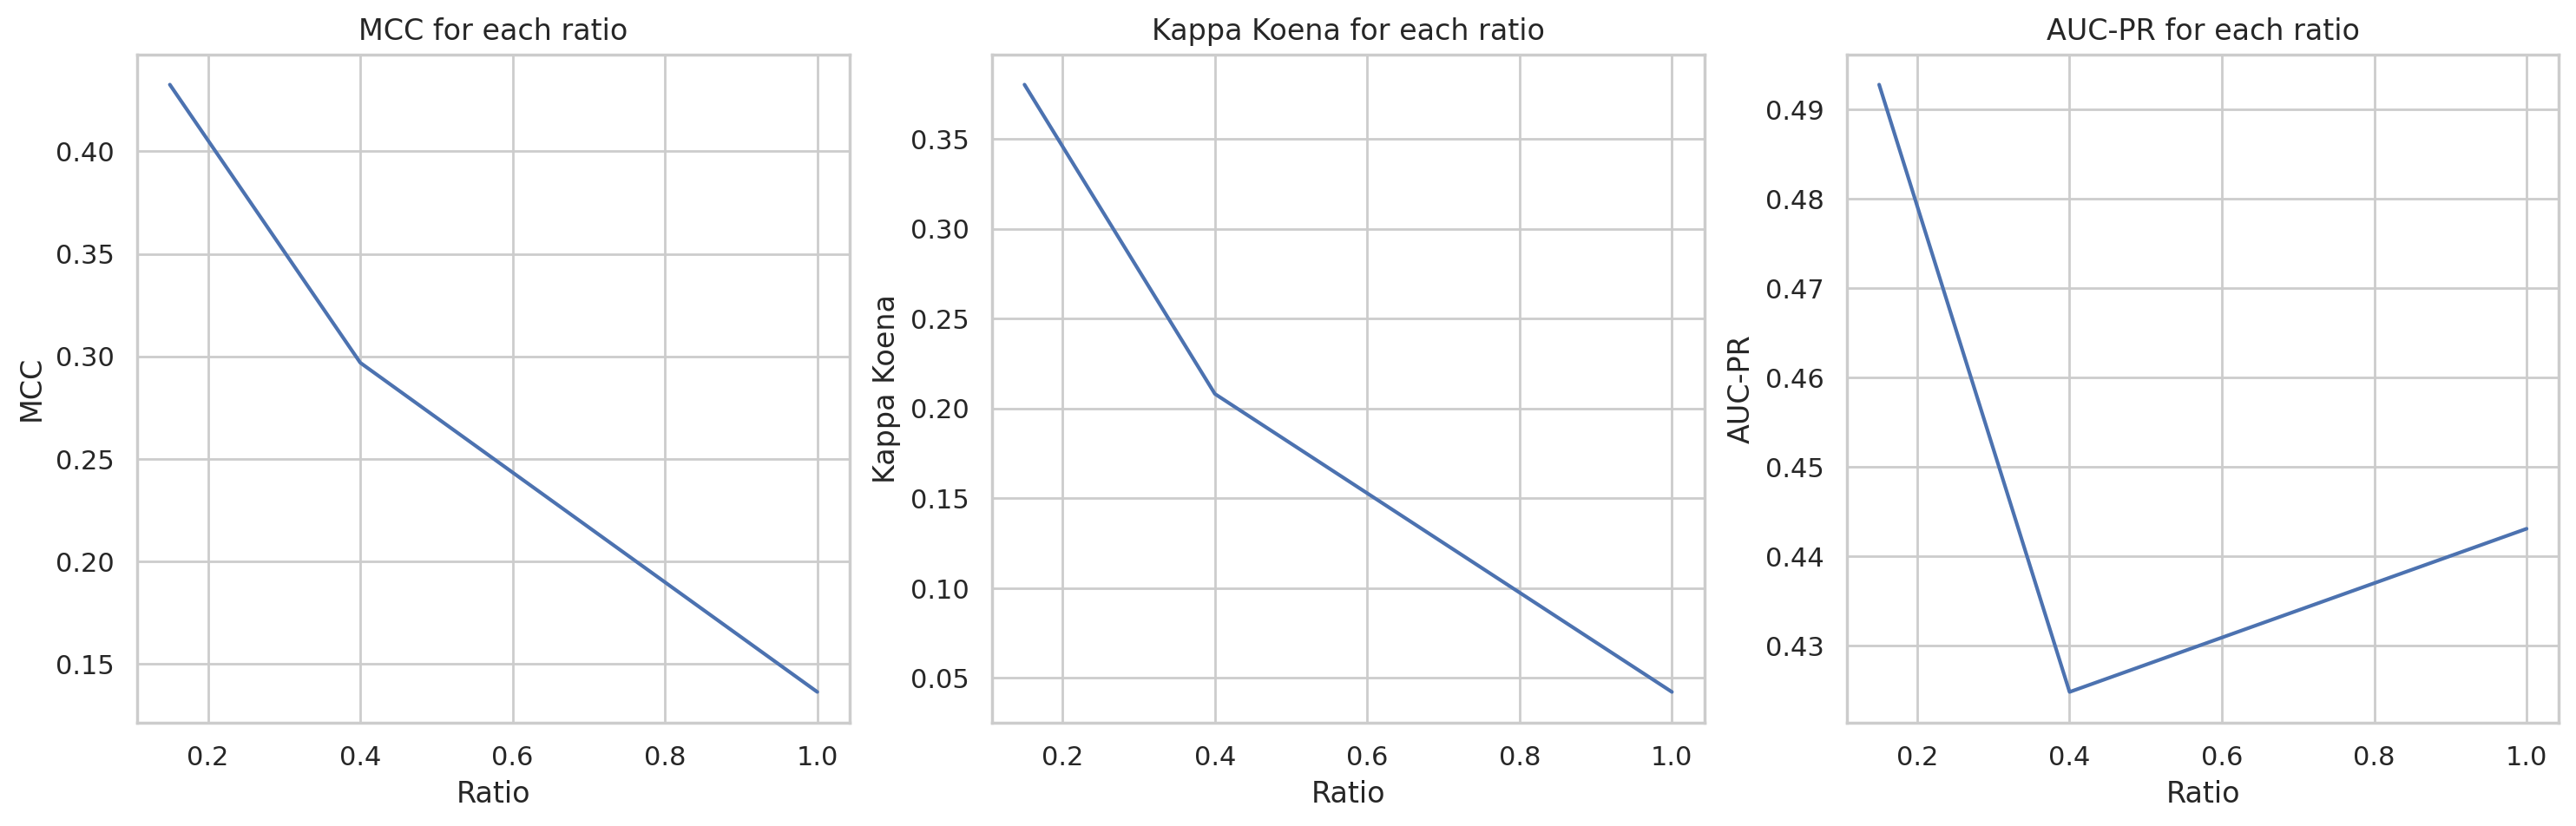

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18,5), dpi=200, squeeze=False)

axs[0][0].set_title('MCC for each ratio')
axs[0][0].plot([0.15, 0.4, 1], [MCC(y_test, pred_proba_ru), MCC(y_test, pred_proba_ru_4), MCC(y_test, pred_proba_ru_full)])
axs[0][0].set_xlabel('Ratio')
axs[0][0].set_ylabel('MCC')
axs[0][0].grid(True)

axs[0][1].set_title('Kappa Koena for each ratio')
axs[0][1].plot([0.15, 0.4, 1], [Kappa_Koena(y_test, pred_proba_ru), Kappa_Koena(y_test, pred_proba_ru_4), Kappa_Koena(y_test, pred_proba_ru_full)])
axs[0][1].set_xlabel('Ratio')
axs[0][1].set_ylabel('Kappa Koena')
axs[0][1].grid(True)

axs[0][2].set_title('AUC-PR for each ratio')
axs[0][2].plot([0.15, 0.4, 1], [auc_pr(y_test, pred_proba_ru), auc_pr(y_test, pred_proba_ru_4), auc_pr(y_test, pred_proba_ru_full)])
axs[0][2].set_xlabel('Ratio')
axs[0][2].set_ylabel('AUC-PR')
axs[0][2].grid(True)

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [ ]:
from imblearn.under_sampling import NearMiss

nm_k_3 = NearMiss(sampling_strategy=0.15, n_neighbors=3)
X_nm_3, y_nm_3 = nm_k_3.fit_resample(X_train, y_train)

In [ ]:
from imblearn.under_sampling import NearMiss

nm_k_3_m = NearMiss(sampling_strategy=0.5, n_neighbors=3)
X_nm_3_m, y_nm_3_m = nm_k_3_m.fit_resample(X_train, y_train)

In [ ]:
from imblearn.under_sampling import NearMiss

nm_k_5 = NearMiss(sampling_strategy=0.15, n_neighbors=5)
X_nm_5, y_nm_5 = nm_k_5.fit_resample(X_train, y_train)

In [ ]:
from imblearn.under_sampling import NearMiss

nm_k_5_m = NearMiss(sampling_strategy=0.5, n_neighbors=5)
X_nm_5_m, y_nm_5_m = nm_k_5_m.fit_resample(X_train, y_train)

Не буду подбирать гиперпараметры, так как это будет ну очень долго.

In [ ]:
cat = CatBoostClassifier(
    **{'iterations': 3000, 'learning_rate': 0.1, 'depth': 7},
    random_state=52, verbose=False, task_type=device
                                   )

In [ ]:
cat.fit(X_nm_3, y_nm_3)
pred_nm_3 = cat.predict(X_test)

mcc_nm_3 = MCC(y_test, pred_nm_3)
kk_nm_3 = Kappa_Koena(y_test, pred_nm_3)
auc_pr_nm_3 = auc_pr(y_test, pred_nm_3)

In [ ]:
cat.fit(X_nm_3_m, y_nm_3_m)
pred_nm_3_m = cat.predict(X_test)

mcc_nm_3_m = MCC(y_test, pred_nm_3_m)
kk_nm_3_m = Kappa_Koena(y_test, pred_nm_3_m)
auc_pr_nm_3_m = auc_pr(y_test, pred_nm_3_m)

In [ ]:
cat.fit(X_nm_5, y_nm_5)
pred_nm_5 = cat.predict(X_test)

mcc_nm_5 = MCC(y_test, pred_nm_5)
kk_nm_5 = Kappa_Koena(y_test, pred_nm_5)
auc_pr_nm_5 = auc_pr(y_test, pred_nm_5)

In [ ]:
cat.fit(X_nm_5_m, y_nm_5_m)
pred_nm_5_m = cat.predict(X_test)

mcc_nm_5_m = MCC(y_test, pred_nm_5_m)
kk_nm_5_m = Kappa_Koena(y_test, pred_nm_5_m)
auc_pr_nm_5_m = auc_pr(y_test, pred_nm_5_m)

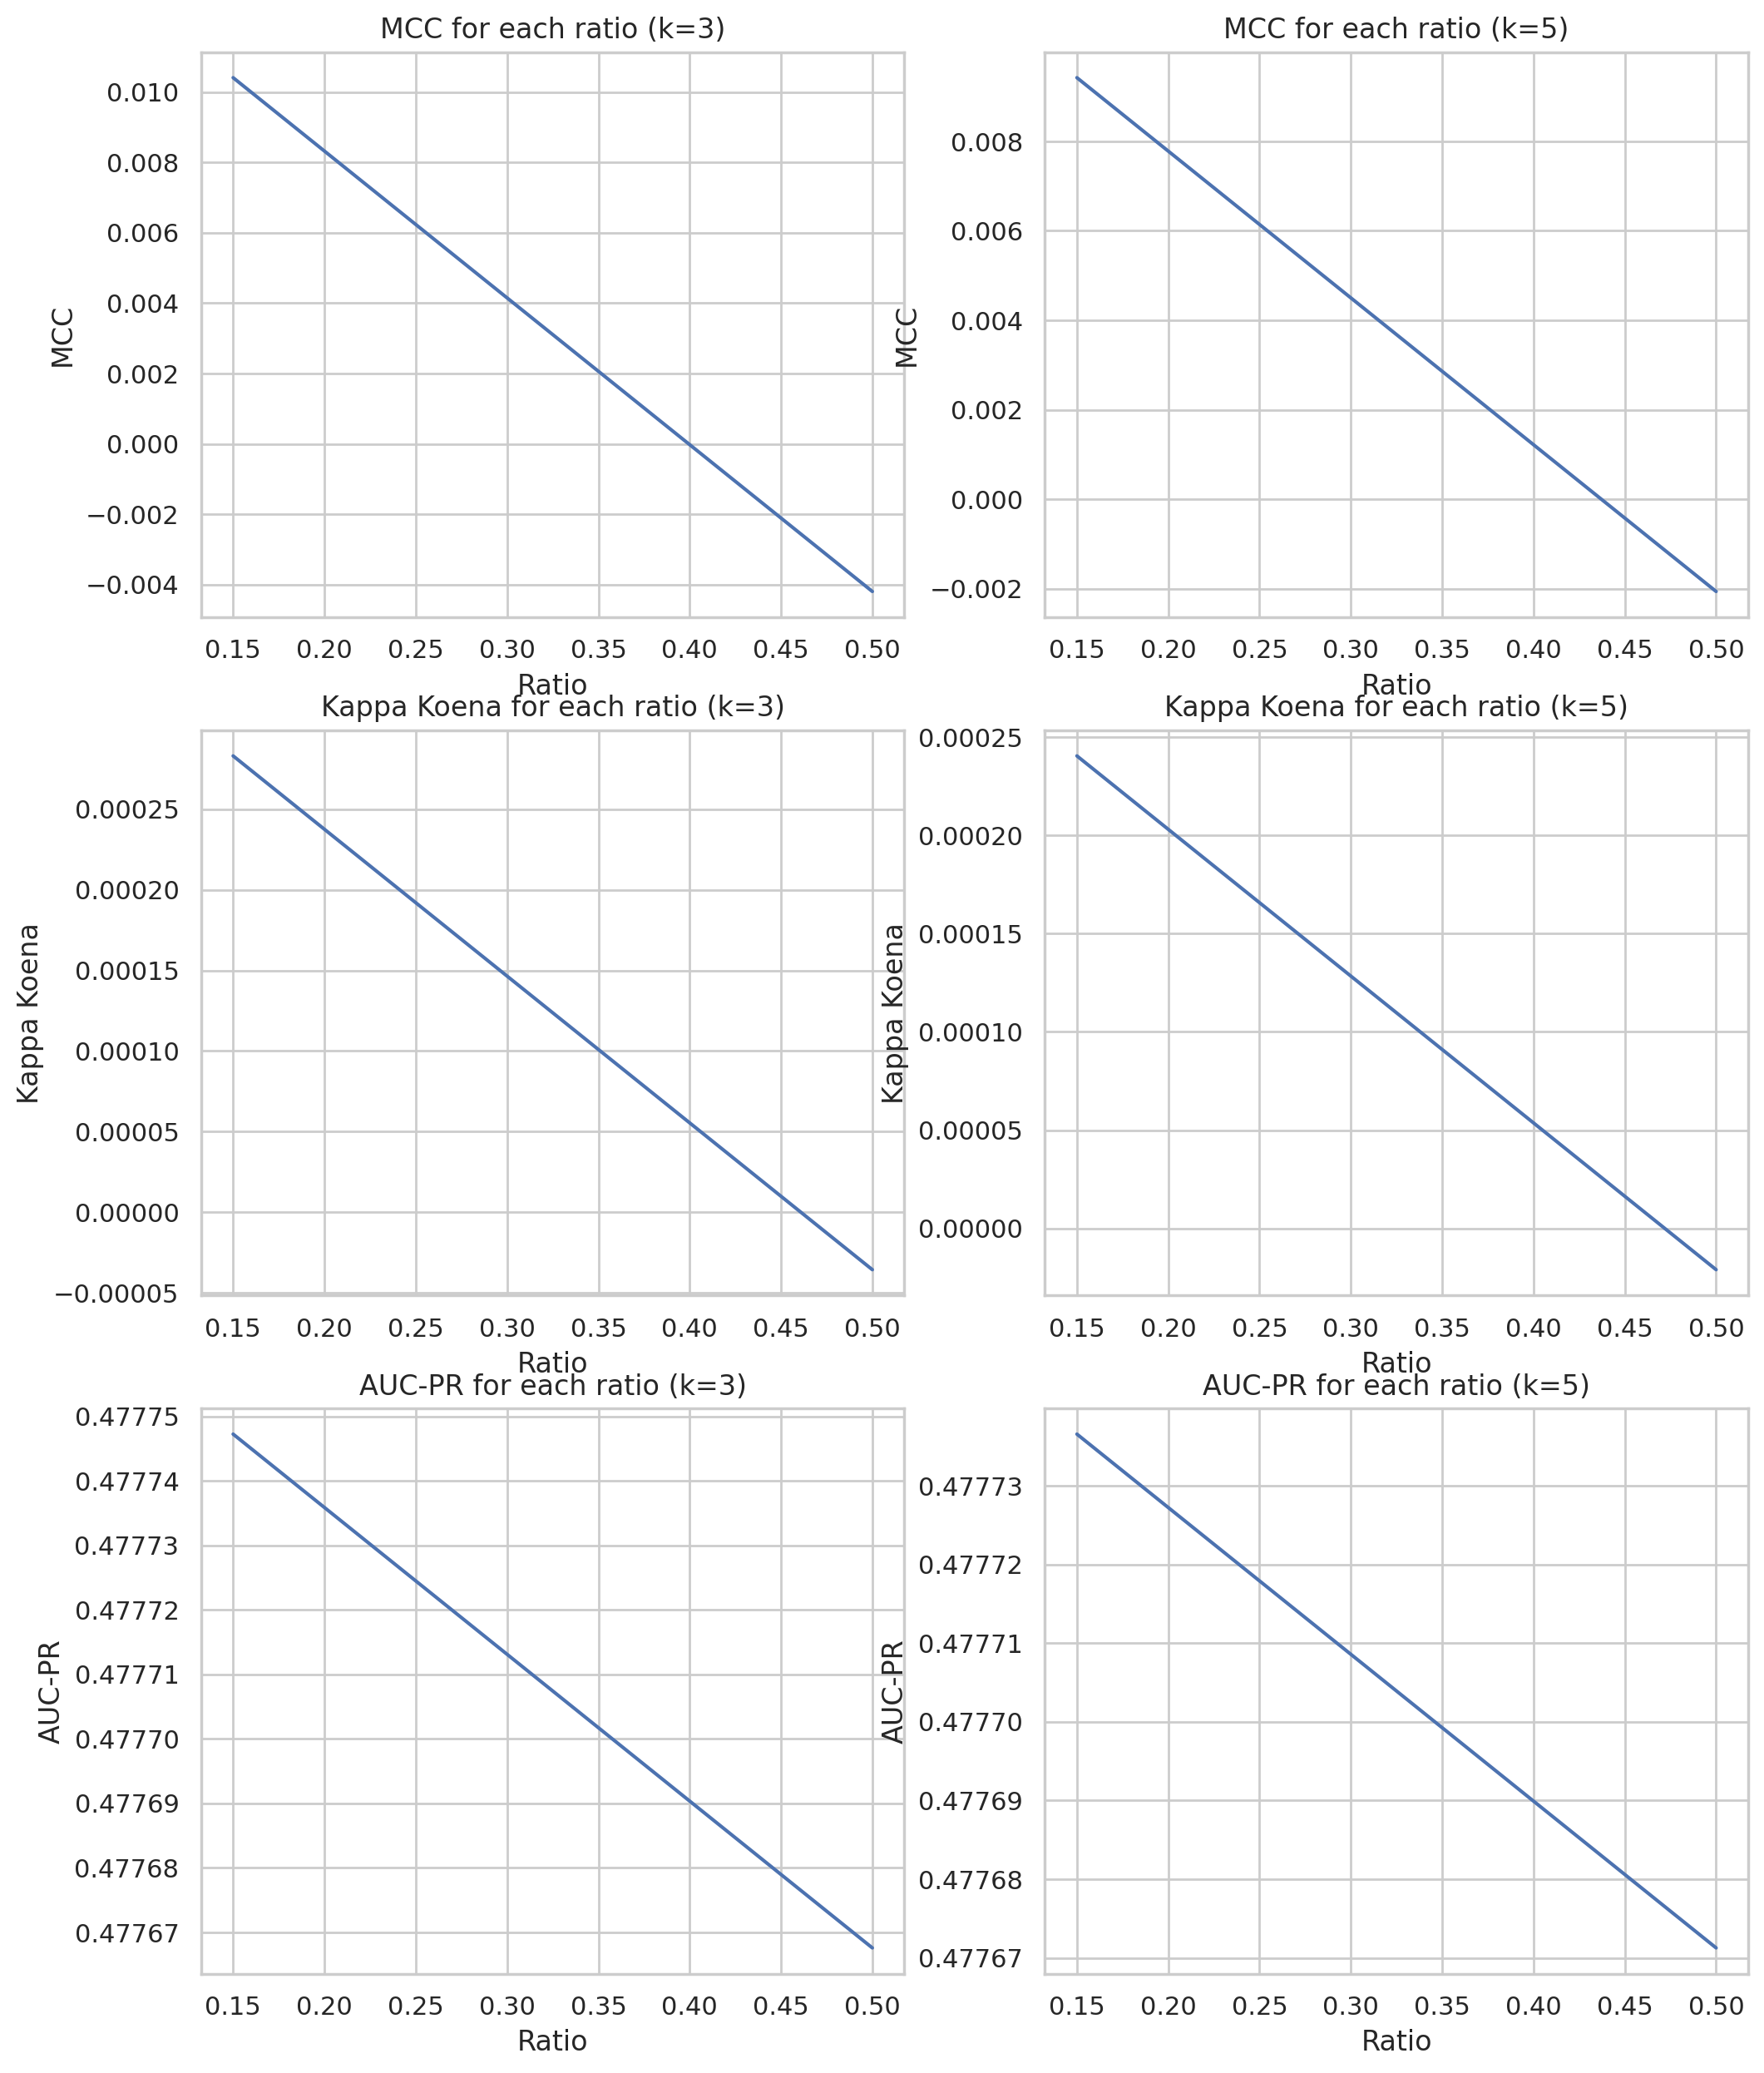

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(12,15), dpi=200, squeeze=False)

axs[0][0].set_title('MCC for each ratio (k=3)')
axs[0][0].plot([0.15, 0.5], [mcc_nm_3, mcc_nm_3_m])
axs[0][0].set_xlabel('Ratio')
axs[0][0].set_ylabel('MCC')
axs[0][0].grid(True)

axs[0][1].set_title('MCC for each ratio (k=5)')
axs[0][1].plot([0.15, 0.5], [mcc_nm_5, mcc_nm_5_m])
axs[0][1].set_xlabel('Ratio')
axs[0][1].set_ylabel('MCC')
axs[0][1].grid(True)

axs[1][0].set_title('Kappa Koena for each ratio (k=3)')
axs[1][0].plot([0.15, 0.5], [kk_nm_3, kk_nm_3_m])
axs[1][0].set_xlabel('Ratio')
axs[1][0].set_ylabel('Kappa Koena')
axs[1][0].grid(True)

axs[1][1].set_title('Kappa Koena for each ratio (k=5)')
axs[1][1].plot([0.15, 0.5], [kk_nm_5, kk_nm_5_m])
axs[1][1].set_xlabel('Ratio')
axs[1][1].set_ylabel('Kappa Koena')
axs[1][1].grid(True)

axs[2][0].set_title('AUC-PR for each ratio (k=3)')
axs[2][0].plot([0.15, 0.5], [auc_pr_nm_3, auc_pr_nm_3_m])
axs[2][0].set_xlabel('Ratio')
axs[2][0].set_ylabel('AUC-PR')
axs[2][0].grid(True)

axs[2][1].set_title('AUC-PR for each ratio (k=5)')
axs[2][1].plot([0.15, 0.5], [auc_pr_nm_5, auc_pr_nm_5_m])
axs[2][1].set_xlabel('Ratio')
axs[2][1].set_ylabel('AUC-PR')
axs[2][1].grid(True)

Ну я зря кнш взял маленький k. Надо было брать 10-20, но все равно качество будет очень так себе.

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.


Я возьму ClusterCentroids метод. Он заменяет объекты мажоритарного класса на центроиды их кластеров, полученных с помощью алгоритма K-Means.

In [ ]:
from imblearn.under_sampling import ClusterCentroids

In [ ]:
cc = ClusterCentroids(sampling_strategy=0.2,random_state=52)

X_train_cc, y_train_cc = cc.fit_resample(X_train, y_train)

In [ ]:
cat = CatBoostClassifier(
    **{'iterations': 3000, 'learning_rate': 0.1, 'depth': 7},
    random_state=52, verbose=False, task_type=device
                                   )
cat.fit(X_train_cc, y_train_cc)
pred_cc = cat.predict(X_test)

print(f"MCC score for Cluster Centroids (0.2) {MCC(y_test, pred_cc)}")
print(f"Kappa Koena score for Cluster Centroids (0.2) {Kappa_Koena(y_test, pred_cc)}")
print(f"AUC-PR score for Cluster Centroids (0.2) {auc_pr(y_test, pred_cc)}")

MCC score for Cluster Centroids (0.2) 0.07082536195991862
Kappa Koena score for Cluster Centroids (0.2) 0.013208649940804501
AUC-PR score for Cluster Centroids (0.2) 0.39016644914546145


Работает долго, ужасное качество...

# Часть 2. Поиск аномалий.

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка.

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных).

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову).

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.
- При желании, можете вынести этот код в отдельный файл и приложить его к ноутбуку. Он довольно громоздкий и в ноутбуке такое плохо читается.


**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [ ]:
def c_factor(n, method:str = 'rabotyaga'):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """

    if method not in ['rabotyaga', 'matematik']:
      raise AttributeError('Пикни то, что было на лекции')

    if method == 'rabotyaga':
      if n <= 1:
        c_n = 0
      else:
        c_n = np.ceil(np.log2(n))

    elif method == 'matematik':
      if n <= 1:
        c_n = 0
      else:
        c_n = np.ceil(2*(np.log(n-1) + 0.5772) - 2*((n-1)/n))

    return int(c_n)

def calc_height(X, depth, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node

        depth: int - path length up to current node

        node: Node - current tree node

    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    scores = np.zeros(X.shape[0])

    if node.kind == "external":
        scores[:] = depth + c_factor(node.size)
        return scores

    porog = np.dot(X, node.w)
    left_part = porog < node.b

    scores[left_part] = calc_height(X[left_part], depth + 1, node.left)
    scores[~left_part] = calc_height(X[~left_part], depth + 1, node.right)

    return scores


class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.

    Attributes:
        X: np.array - data available to current node
        size: int - length of available data

        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.

        Params:
            X: np.array - data available to current node
            depth: int - depth of node

            left: Node - left child
            right: Node - right child

            kind: str - either "internal" or "external", indicates the type of current node

            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane

        """
        self.size = len(X)

        self.depth = depth

        self.left = left
        self.right = right

        self.kind = kind

        self.w = w
        self.b = b

    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth

        max_depth: int - maximum tree depth

        root: Node - root node

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes

    """
    def __init__(self, X, max_depth):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth

        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)

    def __repr__(self):
        """
        For convenience only.
        """

        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"


    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample

            depth: int - current tree depth

        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        if depth >= self.max_depth or X.shape[0] <= 1:
          self.external_count += 1
          return Node(X, depth, None, None, "external", None, None)

        w = np.random.normal(0, 1, X.shape[1]) #Рандомная гиперплоскость
        w /= np.linalg.norm(w)

        projections = np.dot(X, w)
        min_proj, max_proj = np.min(projections), np.max(projections)

        if min_proj == max_proj:
          self.external_count += 1
          return Node(X, depth, None, None, "external", None, None)

        b = np.random.uniform(min_proj, max_proj)

        left_part = projections < b
        X_left_part = X[left_part]
        X_right_part = X[~left_part]

        self.internal_count += 1
        left_node = self.grow(X_left_part, depth + 1)
        right_node = self.grow(X_right_part, depth + 1)

        return Node(X, depth, left_node, right_node, "internal", w, b)

    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated

        Returns:
            scores: np.array - estimated anomaly scores
        """

        path_lengths = calc_height(X, 0, self.root)
        c_n = c_factor(self.root.size)

        scores = path_lengths / c_n

        return scores


class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees

        max_depth: int - maximum depth of each tree

        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

        trees: list - container for trained trees

        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

    """

    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False

    def __repr__(self):
        """For convenience only."""

        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"

    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        n_samples = int(self.subsample_rate * X.shape[0])
        if self.max_depth is None:
          self.max_depth = int(np.ceil(np.log2(n_samples)))

        self.trees = []
        for i in tqdm(range(self.n_trees)):
          indices = np.random.choice(X.shape[0], n_samples, replace=False)
          X_subsample = X.iloc[indices]
          tree = RandomizedTree(X_subsample, self.max_depth)
          self.trees.append(tree)

        self.is_fit = True
        return self

    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        all_scores = np.array([tree.score_samples(X) for tree in self.trees])
        avg_path_length = np.mean(all_scores, axis=0)
        scores = 2 ** (-avg_path_length)

        return scores


    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        scores = self.score_samples(X)
        threshold = np.percentile(scores, 100 * (1 - self.contamination))
        labels = (scores >= threshold).astype(int)

        return labels

In [ ]:
model = ExtendedIsolationForest(n_trees=8, subsample_rate=0.7, max_depth=5, contamination=0.01)

model.fit(X_train)

  0%|          | 0/8 [00:00<?, ?it/s]

ExtendedIsolationForest(n_trees=8, max_depth=5, subsample_rate=0.7, contamination=0.01, is_fit=True)

In [ ]:
pred = model.predict(X_test)

In [ ]:
pd.Series(pred).value_counts()

,count
0,28173
1,308


На рандомных гиперпараметрах работает. УРАААА 🥳🥳

**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [ ]:
st_scaler = StandardScaler()

X_train_st = st_scaler.fit_transform(X_train)
X_train_st = pd.DataFrame(X_train_st, columns = X_train.columns)

X_val_st = st_scaler.transform(X_val)
X_val_st = pd.DataFrame(X_val_st, columns=X_val.columns)

X_test_st = st_scaler.transform(X_test)
X_test_st = pd.DataFrame(X_test_st, columns = X_test.columns)

In [ ]:
def objective(trial):
      param = {
      'n_trees' : trial.suggest_int('n_trees', 10, 301),
      'max_depth' : trial.suggest_int('max_depth', 2, 11),
      'subsample_rate' : trial.suggest_float('subsample_rate', 0.05, 0.6),
      'contamination' : trial.suggest_float('contamination', 0.01, 0.1),
      }

      model = ExtendedIsolationForest(**param)
      model_fitted = model.fit(X_train_st)
      pred = model_fitted.predict(X_val_st)
      kk_score = Kappa_Koena(y_val, pred)
      mcc_score = MCC(y_val, pred)
      auc_pr_score = auc_pr(y_val, pred)

      return kk_score, mcc_score, auc_pr_score


study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
study.optimize(objective, n_trials=20)

trials = study.best_trials

best_trials = study.best_trials

for i in range(len(best_trials)):
  print(f'{best_trials[i].params} best metrics {best_trials[i].values}')

[I 2025-05-09 10:51:55,147] A new study created in memory with name: no-name-28cc7b7b-3db9-4dc9-81c9-0525ec1cd3e4


  0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-09 10:51:59,208] Trial 0 finished with values: [0.027884005123635168, 0.11384338564526073, 0.4703304567477422] and parameters: {'n_trees': 49, 'max_depth': 4, 'subsample_rate': 0.15516315773727643, 'contamination': 0.0932329594574873}.


  0%|          | 0/53 [00:00<?, ?it/s]

[I 2025-05-09 10:52:35,822] Trial 1 finished with values: [0.02855183322995056, 0.1113151024892088, 0.44226147730347903] and parameters: {'n_trees': 53, 'max_depth': 11, 'subsample_rate': 0.35890650515581424, 'contamination': 0.09849654618759111}.


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2025-05-09 10:53:08,940] Trial 2 finished with values: [0.040433132743750495, 0.13326216533174473, 0.44534862028348] and parameters: {'n_trees': 250, 'max_depth': 8, 'subsample_rate': 0.12443352499278745, 'contamination': 0.07168291129434229}.


  0%|          | 0/178 [00:00<?, ?it/s]

[I 2025-05-09 10:53:26,567] Trial 3 finished with values: [0.03518658096877329, 0.1254439445517545, 0.45339213218581487] and parameters: {'n_trees': 178, 'max_depth': 7, 'subsample_rate': 0.10133140503605827, 'contamination': 0.08315784909352336}.


  0%|          | 0/42 [00:00<?, ?it/s]

[I 2025-05-09 10:53:30,002] Trial 4 finished with values: [0.04090933299387897, 0.11807934548530352, 0.3513860542393867] and parameters: {'n_trees': 42, 'max_depth': 2, 'subsample_rate': 0.17821283878770633, 'contamination': 0.04916759712075051}.


  0%|          | 0/246 [00:00<?, ?it/s]

[I 2025-05-09 10:54:09,326] Trial 5 finished with values: [0.03700241447514481, 0.1301950247324339, 0.4632761883346198] and parameters: {'n_trees': 246, 'max_depth': 6, 'subsample_rate': 0.4302599036278617, 'contamination': 0.08104420965896512}.


  0%|          | 0/228 [00:00<?, ?it/s]

[I 2025-05-09 10:54:42,668] Trial 6 finished with values: [0.02863088078560799, 0.11147427732376897, 0.44228187440592504] and parameters: {'n_trees': 228, 'max_depth': 11, 'subsample_rate': 0.057829864393823927, 'contamination': 0.09834551435223922}.


  0%|          | 0/206 [00:00<?, ?it/s]

[I 2025-05-09 10:55:21,985] Trial 7 finished with values: [0.061700810142119755, 0.16046159455202852, 0.42277840738135375] and parameters: {'n_trees': 206, 'max_depth': 6, 'subsample_rate': 0.5527051238858425, 'contamination': 0.04425749570302246}.


  0%|          | 0/85 [00:00<?, ?it/s]

[I 2025-05-09 10:55:33,081] Trial 8 finished with values: [0.06332379187753408, 0.16266636989962807, 0.423216692895062] and parameters: {'n_trees': 85, 'max_depth': 4, 'subsample_rate': 0.4912514034898498, 'contamination': 0.04190735130617905}.


  0%|          | 0/242 [00:00<?, ?it/s]

[I 2025-05-09 10:56:33,551] Trial 9 finished with values: [0.13046597827741374, 0.20628507811006078, 0.33046041180585684] and parameters: {'n_trees': 242, 'max_depth': 9, 'subsample_rate': 0.40477620495674993, 'contamination': 0.014434926509710764}.


  0%|          | 0/301 [00:00<?, ?it/s]

[I 2025-05-09 10:58:31,242] Trial 10 finished with values: [0.043383900933636595, 0.14132762164851556, 0.4649420145922278] and parameters: {'n_trees': 301, 'max_depth': 11, 'subsample_rate': 0.5352772853013706, 'contamination': 0.0700842432354692}.


  0%|          | 0/272 [00:00<?, ?it/s]

[I 2025-05-09 10:59:35,772] Trial 11 finished with values: [0.05553588442741187, 0.15887301995769768, 0.458741507914568] and parameters: {'n_trees': 272, 'max_depth': 7, 'subsample_rate': 0.5923404963611875, 'contamination': 0.05405090767872552}.


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-05-09 10:59:41,688] Trial 12 finished with values: [0.029947898412913145, 0.11808893391734558, 0.47086204462042736] and parameters: {'n_trees': 80, 'max_depth': 3, 'subsample_rate': 0.26925326850686554, 'contamination': 0.09601088048084566}.


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-05-09 11:00:23,605] Trial 13 finished with values: [0.09378482602237617, 0.20028152135480914, 0.43161530949087173] and parameters: {'n_trees': 200, 'max_depth': 8, 'subsample_rate': 0.33450488918844157, 'contamination': 0.02923517846704589}.


  0%|          | 0/288 [00:00<?, ?it/s]

[I 2025-05-09 11:01:36,636] Trial 14 finished with values: [0.06468562894067781, 0.16828806340555827, 0.4423852818267275] and parameters: {'n_trees': 288, 'max_depth': 10, 'subsample_rate': 0.32909613273561145, 'contamination': 0.04458010349961141}.


  0%|          | 0/63 [00:00<?, ?it/s]

[I 2025-05-09 11:02:02,411] Trial 15 finished with values: [0.03894535999298084, 0.12919555836439198, 0.4355488237630958] and parameters: {'n_trees': 63, 'max_depth': 11, 'subsample_rate': 0.5806304121324157, 'contamination': 0.07210425277401979}.


  0%|          | 0/116 [00:00<?, ?it/s]

[I 2025-05-09 11:02:17,467] Trial 16 finished with values: [0.07271685547999719, 0.17895516143827803, 0.4445626455979007] and parameters: {'n_trees': 116, 'max_depth': 4, 'subsample_rate': 0.5243156402248615, 'contamination': 0.03926821148859604}.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-05-09 11:02:25,463] Trial 17 finished with values: [0.12315034548987716, 0.19675212916967572, 0.3188836387895644] and parameters: {'n_trees': 30, 'max_depth': 11, 'subsample_rate': 0.16008688655518064, 'contamination': 0.014806060122505994}.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-05-09 11:02:29,146] Trial 18 finished with values: [0.06465915896992926, 0.1485252612347038, 0.34841665482073264] and parameters: {'n_trees': 40, 'max_depth': 3, 'subsample_rate': 0.46423586234984776, 'contamination': 0.03271643268556488}.


  0%|          | 0/108 [00:00<?, ?it/s]

[I 2025-05-09 11:02:40,598] Trial 19 finished with values: [0.03376536001383101, 0.11997878934845616, 0.4341986066223733] and parameters: {'n_trees': 108, 'max_depth': 6, 'subsample_rate': 0.1671363660669421, 'contamination': 0.08177861959793838}.


{'n_trees': 242, 'max_depth': 9, 'subsample_rate': 0.40477620495674993, 'contamination': 0.014434926509710764} best metrics [0.13046597827741374, 0.20628507811006078, 0.33046041180585684]
{'n_trees': 301, 'max_depth': 11, 'subsample_rate': 0.5352772853013706, 'contamination': 0.0700842432354692} best metrics [0.043383900933636595, 0.14132762164851556, 0.4649420145922278]
{'n_trees': 272, 'max_depth': 7, 'subsample_rate': 0.5923404963611875, 'contamination': 0.05405090767872552} best metrics [0.05553588442741187, 0.15887301995769768, 0.458741507914568]
{'n_trees': 80, 'max_depth': 3, 'subsample_rate': 0.26925326850686554, 'contamination': 0.09601088048084566} best metrics [0.029947898412913145, 0.11808893391734558, 0.47086204462042736]
{'n_trees': 200, 'max_depth': 8, 'subsample_rate': 0.33450488918844157, 'contamination': 0.02923517846704589} best metrics [0.09378482602237617, 0.20028152135480914, 0.43161530949087173]
{'n_trees': 116, 'max_depth': 4, 'subsample_rate': 0.524315640224861

In [ ]:
eif = ExtendedIsolationForest(n_trees = 242, max_depth = 9, subsample_rate = 0.40477620495674993, contamination = 0.01)

eif.fit(X_train_st)
pred_eif = eif.predict(X_test_st)

print(f"MCC score for Extended Isolation Forest {MCC(y_test, pred_eif)}")
print(f"Kappa Koena score for Extended Isolation Forest {Kappa_Koena(y_test, pred_eif)}")
print(f"AUC-PR score for Extended Isolation Forest {auc_pr(y_test, pred_eif)}")

  0%|          | 0/242 [00:00<?, ?it/s]

MCC score for Extended Isolation Forest 0.12417959298781006
Kappa Koena score for Extended Isolation Forest 0.06380390526904328
AUC-PR score for Extended Isolation Forest 0.24502725368214645


In [ ]:
is_for = IsolationForest(n_estimators=242, contamination=0.01, random_state=52)

is_for.fit(X_train_st)
pred_is_for = is_for.predict(X_test_st)

pred_is_for = np.where(pred_is_for == -1, 1, 0) #тут перепутанно -1 это аномалия, а 1 это норм


print(f"MCC score for Isolation Forest {MCC(y_test, pred_is_for)}")
print(f"Kappa Koena score for Isolation Forest {Kappa_Koena(y_test, pred_is_for)}")
print(f"AUC-PR score for Isolation Forest {auc_pr(y_test, pred_is_for)}")

MCC score for Isolation Forest 0.11606971022034847
Kappa Koena score for Isolation Forest 0.06796130543548755
AUC-PR score for Isolation Forest 0.20120271568605547


Наш isolation forest лучше, чем из sklearn, но и там и там качество сильно хуже catboost-а, как-то даже грустно, что столько времени я потратил, чтобы в итоге оказалось плохим методом.

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [ ]:
lof = LocalOutlierFactor(novelty=True)
lof.fit(X_train_st)

pred_lof = lof.predict(X_test_st)

pred_lof = np.where(pred_lof == -1, 1, 0)

print(f"MCC score for LOF {MCC(y_test, pred_lof)}")
print(f"Kappa Koena score for LOF {Kappa_Koena(y_test, pred_lof)}")
print(f"AUC-PR score for LOF {auc_pr(y_test, pred_lof)}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


MCC score for LOF -0.003675749091675918
Kappa Koena score for LOF -0.0002594193228043386
AUC-PR score for LOF 0.15967557930220497


In [ ]:
o_svm = OneClassSVM(gamma=50, max_iter = 2500)
mod = o_svm.fit(X_train_st)

pred_svm = mod.predict(X_test_st)

pred_svm = np.where(pred_svm == -1, 1, 0)

print(f"MCC score for O-SVM {MCC(y_test, pred_svm)}")
print(f"Kappa Koena score for O-SVM {Kappa_Koena(y_test, pred_svm)}")
print(f"AUC-PR score for O-SVM {auc_pr(y_test, pred_svm)}")

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MCC score for O-SVM 0.0
Kappa Koena score for O-SVM 0.0
AUC-PR score for O-SVM 0.5003862223938766


Для SVM ждал 40 минут, чтобы в конце выдало случанйное предсказание, хахахахахахахахахаахахах

У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

Я тут не буду новые фичи придумывать, я буду пробовать все то, что хотел все это время.

In [ ]:
X_train_new = X_train[['V10', 'V12', 'V14', 'V17', 'hour']] #Мы эти признаки так и не использовали в сухую
X_val_new = X_val[['V10', 'V12', 'V14', 'V17', 'hour']]
X_test_new = X_test[['V10', 'V12', 'V14', 'V17', 'hour']]

In [ ]:
kms = KMeansSMOTE(sampling_strategy=0.2, random_state=52, cluster_balance_threshold=0.00001)
X_train_kms_new, y_train_kms_new = kms.fit_resample(X_train_new, y_train)

In [ ]:
def objective(trial):
      param = {
      'iterations' : trial.suggest_int('iterations', 3000, 7001),
      'learning_rate' : trial.suggest_float('learning_rate', 0.05, 0.5),
      'depth' : trial.suggest_int('depth', 2, 11),
      'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 0.1, 500),
      }

      c = trial.suggest_float('c', 0.5, 0.9)

      model = CatBoostClassifier(**param,random_state=52, verbose=False, task_type=device)
      model_fitted = model.fit(X_train_new, y_train)
      pred = model_fitted.predict_proba(X_val_new)[:, 1]
      kk_score = Kappa_Koena(y_val, pred, c=c)
      mcc_score = MCC(y_val, pred, c=c)
      auc_pr_score = auc_pr(y_val, pred, c=c)

      return kk_score, mcc_score, auc_pr_score

study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
study.optimize(objective, n_trials=10)

trials = study.best_trials

best_trials = study.best_trials

for i in range(len(best_trials)):
  print(f'{best_trials[i].params} best metrics {best_trials[i].values}')

[I 2025-05-09 16:05:58,731] A new study created in memory with name: no-name-7f396057-46d7-465b-8f79-f86cbe9f3027
[I 2025-05-09 16:06:23,504] Trial 0 finished with values: [0.8081992825683761, 0.8148884531057727, 0.8221685336344476] and parameters: {'iterations': 4881, 'learning_rate': 0.31944101545928916, 'depth': 3, 'scale_pos_weight': 464.3353526208129, 'c': 0.8758605961891027}.
[I 2025-05-09 16:06:57,241] Trial 1 finished with values: [0.7868880917426402, 0.7934008773303569, 0.8005570049824353] and parameters: {'iterations': 6457, 'learning_rate': 0.06140670686626316, 'depth': 4, 'scale_pos_weight': 354.620582635349, 'c': 0.7092963898739235}.
[I 2025-05-09 16:07:41,393] Trial 2 finished with values: [0.7751258986608983, 0.7777304951793043, 0.7809761217103285] and parameters: {'iterations': 6727, 'learning_rate': 0.47888161159947534, 'depth': 6, 'scale_pos_weight': 187.873201540568, 'c': 0.5536944122179533}.
[I 2025-05-09 16:09:40,697] Trial 3 finished with values: [0.82581213844328

{'iterations': 3481, 'learning_rate': 0.10324224900609927, 'depth': 11, 'scale_pos_weight': 232.60526885596477, 'c': 0.8252389737681511} best metrics [0.8258121384432856, 0.8355744230160397, 0.8459333866675935]
{'iterations': 6397, 'learning_rate': 0.31382876569057244, 'depth': 8, 'scale_pos_weight': 25.02700233621195, 'c': 0.7105072208508909} best metrics [0.8258121384432856, 0.8355744230160397, 0.8459333866675935]
{'iterations': 3801, 'learning_rate': 0.13217960314622432, 'depth': 11, 'scale_pos_weight': 175.7470165254626, 'c': 0.5984690653449511} best metrics [0.8258121384432856, 0.8355744230160397, 0.8459333866675935]


In [ ]:
cat = CatBoostClassifier(**{'iterations': 6397, 'learning_rate': 0.31382876569057244, 'depth': 8, 'scale_pos_weight': 25.02700233621195},
                         random_state=52, verbose=False, task_type=device
                         )

c_new = 0.7105072208508909

cat.fit(X_train_kms_new, y_train_kms_new)

pred_final = cat.predict_proba(X_test_new)[:, 1]

print(f"MCC score {MCC(y_test, pred_final, c = c_new)}")
print(f"Kappa Koena score {Kappa_Koena(y_test, pred_final, c = c_new)}")
print(f"AUC-PR score {auc_pr(y_test, pred_final, c = c_new)}")

MCC score 0.7110586906187203
Kappa Koena score 0.7108828212297992
AUC-PR score 0.7115677839730336


Ну что-то все очень плохо, лучше все признаки использовать.